In [32]:
import os
import sys
import pandas as pd
import numpy as np
import os
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import spacy
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import explained_variance_score, silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from matplotlib.ticker import FixedLocator, FixedFormatter
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from scipy.spatial.distance import cdist
from factor_analyzer.factor_analyzer import calculate_kmo
from openai import OpenAI
import re
import warnings
warnings.filterwarnings('ignore') # Ignore warnings for Kmeans memory leak

In [3]:
# !python -m spacy download de_core_news_sm 
# required to when setting runtime in addition to other package downloads

In [124]:
# Path to your CUDA binary directory for GPU acceleration
cuda_bin_path = "C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.6/bin"

# Add the path to the environment PATH variable
os.environ["PATH"] = cuda_bin_path + os.pathsep + os.environ["PATH"]

if torch.cuda.is_available():
    print(f"Cuda is available")
    device = torch.device("cuda")
else:
    print(f"Cuda is not available")
    device = torch.device("cpu")

# Ensure the NLTK resources and Lemmatizer resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('german')) 
nlp = spacy.load('de_core_news_sm')

#load the model for embedding
model_path = "ibm-granite/granite-embedding-107m-multilingual"
model = SentenceTransformer(model_path)
model = model.to(device)

# func to apply lemmatization with POS tagging using spaCy
def ngrams_with_lemmatization(n_grams):
    lemmatized_ngrams = []
    
    for ngram in n_grams:
        lemmatized_ngram = []
        # Process the ngram using spaCy
        doc = nlp(" ".join(ngram))  # Join the ngram into a single string and process
        
        for token in doc:
            # Skip stopwords, punctuation, and words with fewer than 2 characters
                # Lemmatize based on POS (spaCy automatically uses the correct lemma)
            lemmatized_ngram.append(token.lemma_)
        
        lemmatized_ngrams.append(lemmatized_ngram)
    return lemmatized_ngrams

def count_words_in_list(str_list, num=20):

    # Count the number of occurrences of each string
    string_count = Counter(str_list)

    # Order the count of strings by number of occurrences
    ordered_counts = string_count.most_common()

    # Display the ordered counts
    print(ordered_counts[:num])
    
def get_embedding(word):
    embedding = model.encode(word, device=device)  
    return np.squeeze(embedding)

def calculate_explained_variance_score(original_data, reconstructed_data):
    # Flatten the data to make sure we're comparing each feature across the samples
    original_data_flat = original_data.cpu().numpy()
    reconstructed_data_flat = reconstructed_data.cpu().numpy()
    
    # Compute the explained variance score
    evs = explained_variance_score(original_data_flat, reconstructed_data_flat)
    return evs

def kmeans_ksearch_plots(data, k_range = range(4,30)):
# Define the range of k values
    k_values = k_range
    # Initialize lists to store scores
    silhouette_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []

    # Calculate scores for each k
    for k in k_values:
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(data)
        y_pred = kmeans.labels_

        # Compute metrics
        silhouette_scores.append(silhouette_score(data, y_pred))
        calinski_harabasz_scores.append(calinski_harabasz_score(data, y_pred))
        davies_bouldin_scores.append(davies_bouldin_score(data, y_pred))

    # Plot the results
    plt.figure(figsize=(12, 8))

    # Silhouette Scores
    plt.subplot(3, 1, 1)
    plt.plot(k_values, silhouette_scores, marker='o', label='Silhouette Score')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for Different k')
    plt.grid(True)

    # Calinski-Harabasz Index
    plt.subplot(3, 1, 2)
    plt.plot(k_values, calinski_harabasz_scores, marker='o', color='green', label='Calinski-Harabasz Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Index')
    plt.title('Calinski-Harabasz Index for Different k')
    plt.grid(True)

    # Davies-Bouldin Index
    plt.subplot(3, 1, 3)
    plt.plot(k_values, davies_bouldin_scores, marker='o', color='red', label='Davies-Bouldin Index')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index for Different k')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def kmeans_ellbow_plot(data, k_range=range(4, 30)):
    # Calculate inertia for each k
    kmeans_per_k = [KMeans(n_clusters=k, n_init=40, random_state=42).fit(data) for k in k_range]
    inertias = [model.inertia_ for model in kmeans_per_k]

    # Plot inertia values
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertias, "bo-", label="Inertia")
    plt.xlabel("Number of Clusters ($k$)")
    plt.ylabel("Inertia")
    plt.title("Inertia vs. Number of Clusters ($k$)")
    plt.grid()

    # Dynamic axis limits
    plt.axis([4, np.max(k_range), 0, max(inertias) * 1.1])

    # Add legend and save the figure
    plt.legend()
    plt.show()

def apply_SSD(df, new_col_name="SSD"):
    df[new_col_name] = df.apply(lambda row: np.std(row, ddof=0), axis=1)
    return df

Cuda is available


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\biebe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [18]:

# Path to the folder containing the txt files
folder_path = "Simulationen"

# List to collect rows
rows = []

# Iterate through all txt files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        # Construct full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the file
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
        
        for line in lines:
            # Split speaker and sentence if formatted like "P1: sentence"
            if ": " in line:
                speaker, content = line.split(": ", 1)
                # Tokenize the content into individual sentences
                sentences = sent_tokenize(content)
                for sentence in sentences:
                    # Append each sentence as a row
                    rows.append({"Speaker": speaker.strip(), "Sentence": sentence.strip()})

# Create DataFrame from collected rows
sentence_level_frame = pd.DataFrame(rows)

# Display the resulting DataFrame
print(sentence_level_frame.head(50))

   Speaker                                           Sentence
0       P1                                      Wer ist Pink?
1       P2                                   Bin beschäftigt!
2       P1  Okay, dann warte ich erstmal, ich bin bei dem ...
3       P3  Und wenn du wieder, wenn du wieder rein kommst...
4       P2                               Wie war, wo war der?
5       P1                                Lara, du bist Pink.
6       P2                                  Ne, ich bin Pink!
7       P1                                        Ah, Simone?
8       P1                    Ich bin draußen bei dem Grünen.
9       P1                         Ich bin jetzt ready, Lila.
10      P4                               Einmal zu Rosa raus.
11      P3                              Ah, du bist Rosa, P4?
12      P4  Ja, genau, aber ich muss erst mal schauen, wo ...
13      P1  Ich bin draußen und steh bei dem Grünen, aber ...
14      P1                            Was soll ich jetzt tun?
15      

In [19]:
word_rows = []
# Iterate through sentence-level DataFrame
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha() and word.lower() and word.lower() not in stop_words]
    # Append each word with its associated metadata
    for word in filtered_words:
        # Process each word with spaCy to get its lemma
        doc = nlp(word)
        lemmatized_word = doc[0].lemma_  # Getting the lemmatized version of the word
        word_rows.append({"Speaker": row["Speaker"], "Word": lemmatized_word})

# Create word-level DataFrame
word_level_frame_no_stopwords = pd.DataFrame(word_rows)

#same process with stopwords still included
word_rows = []
for index, row in sentence_level_frame.iterrows():
    # Tokenize each sentence into words
    words = word_tokenize(row["Sentence"])
    filtered_words = [word for word in words if word.isalpha()]
    # Append each word with its associated metadata
    for word in filtered_words:
        # Process each word with spaCy to get its lemma
        doc = nlp(word)
        lemmatized_word = doc[0].lemma_  # Getting the lemmatized version of the word
        word_rows.append({"Speaker": row["Speaker"], "Word": lemmatized_word})
        
# Create word-level DataFrame
word_level_frame_with_stopwords = pd.DataFrame(word_rows)

# Display the resulting DataFrame
print(word_level_frame_no_stopwords.head(10))
print(word_level_frame_with_stopwords.head(10))

  Speaker          Word
0      P1           wer
1      P1          pink
2      P2  beschäftigen
3      P1          Okay
4      P1        warten
5      P1       erstmal
6      P1         grüne
7      P1       draußen
8      P3          rein
9      P3        kommst
  Speaker          Word
0      P1           wer
1      P1          sein
2      P1          pink
3      P2           Bin
4      P2  beschäftigen
5      P1          Okay
6      P1          dann
7      P1        warten
8      P1           ich
9      P1       erstmal


In [7]:


# Create bigrams
bigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 2)))

# Create trigrams
trigrams_with_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_with_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams:", bigrams_with_stopwords)
print("Trigrams:", trigrams_with_stopwords)

# Create bigrams without stopwords
bigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 2)))

# Create trigrams without stopwords
trigrams_no_stopwords = ngrams_with_lemmatization(list(ngrams(list(word_level_frame_no_stopwords["Word"].values), 3)))

# Display the results
print("Bigrams without stopwords:", bigrams_no_stopwords)
print("Trigrams without stopwords:", trigrams_no_stopwords)


Bigrams: [['wer', 'sein'], ['sein', 'pink'], ['pink', 'Bin'], ['Bin', 'beschäftigen'], ['beschäftigen', 'Okay'], ['Okay', 'dann'], ['dann', 'warten'], ['warten', 'ich'], ['ich', 'erstmal'], ['erstmal', 'ich'], ['ich', 'sein'], ['sein', 'bei'], ['bei', 'der'], ['der', 'grüner'], ['grüne', 'draußen'], ['draußen', 'und'], ['und', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'wenn'], ['wenn', 'du'], ['du', 'wieder'], ['wieder', 'rein'], ['rein', 'kommst'], ['kommsen', 'hier'], ['hier', 'links'], ['links', 'da'], ['da', 'hier'], ['hier', 'wie'], ['wie', 'sein'], ['sein', 'wo'], ['wo', 'sein'], ['sein', 'der'], ['der', 'Lara'], ['Lara', 'du'], ['du', 'sein'], ['sein', 'pink'], ['pink', 'Ne'], ['ne', 'ich'], ['ich', 'sein'], ['sein', 'pink'], ['Pink', 'Ah'], ['Ah', 'Simone'], ['Simone', 'ich'], ['ich', 'sein'], ['sein', 'draußen'], ['draußen', 'bei'], ['bei', 'der'], ['der', 'grüner'], ['grüne', 'ich'], ['ich', 'sein'], ['sein', 'jetzt'], ['jetzt', 'ready'], ['ready', 'Lila'], ['Lila

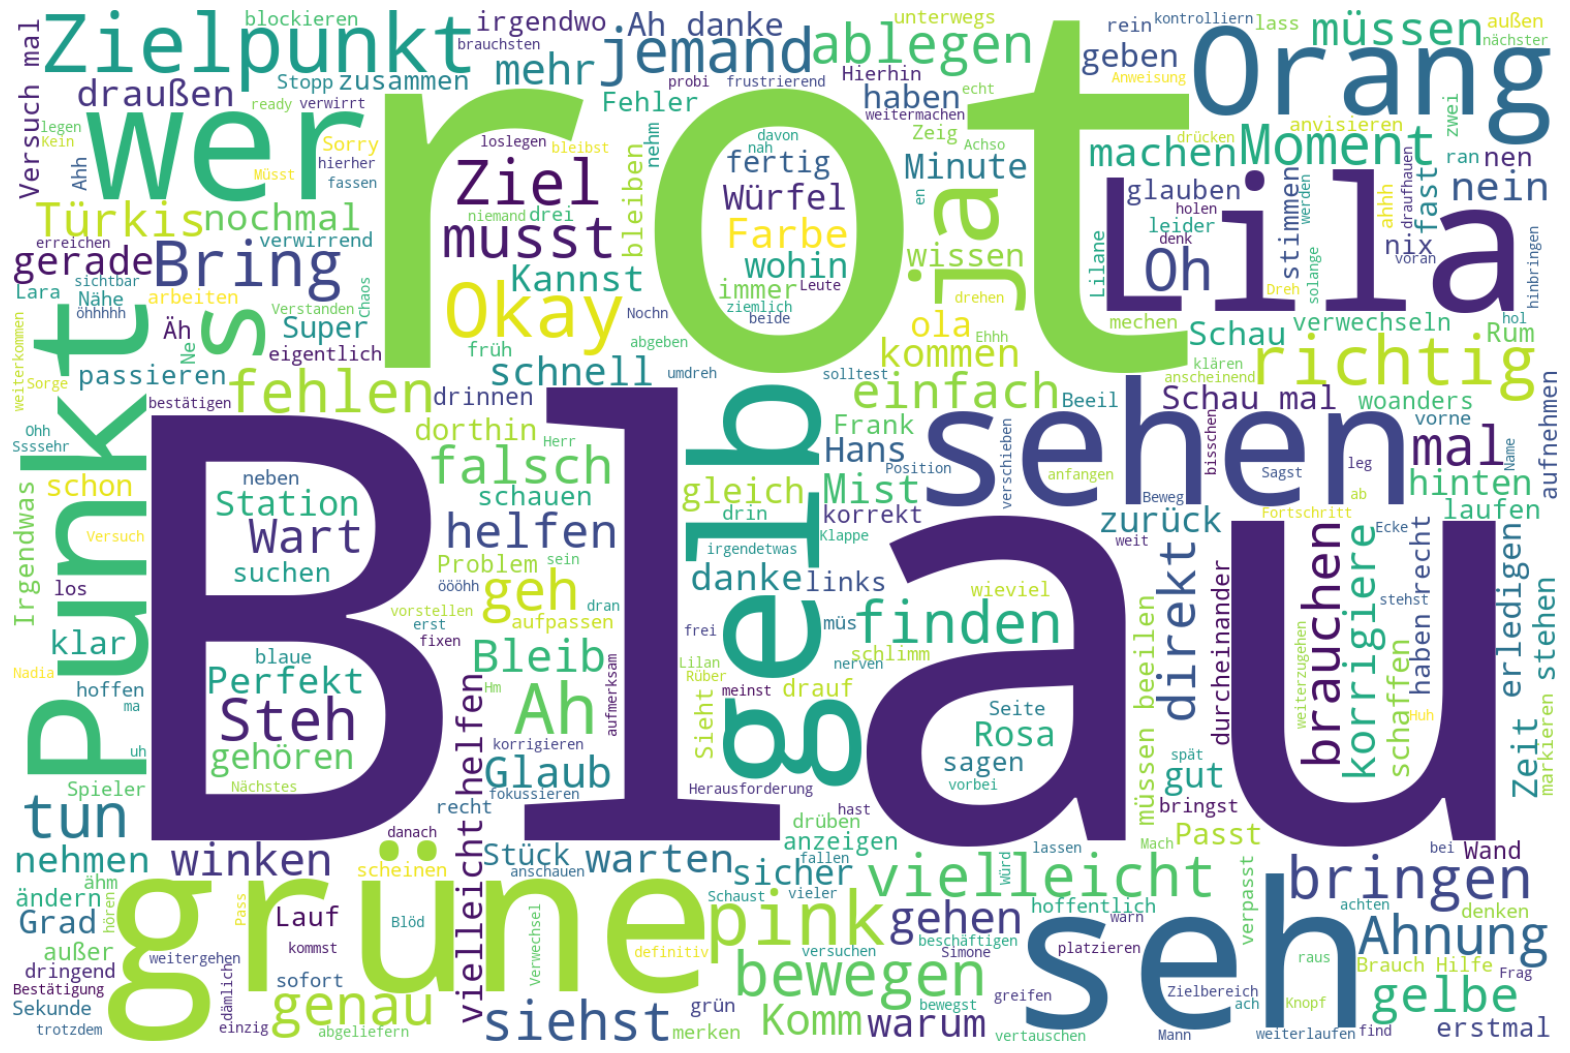

[('Blau', 120), ('rot', 87), ('seh', 79), ('grüne', 78), ('Lila', 66), ('gelb', 59), ('sehen', 55), ('Punkt', 53), ('wer', 50), ('Orang', 45), ('ja', 41), ('s', 39), ('Zielpunkt', 38), ('Ah', 34), ('pink', 29), ('Okay', 27), ('mal', 26), ('richtig', 26), ('vielleicht', 25), ('Bring', 22)]


In [8]:
def makeImage_uni(str_list):

    wc = WordCloud(width=1500, height=1000, background_color="white", max_words=400)
    # generate word cloud
    wc.generate(str_list)
   
    # show
    plt.figure( figsize=(20,20) )
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
makeImage_uni(' '.join(word_level_frame_no_stopwords["Word"].values))

count_words_in_list(word_level_frame_no_stopwords["Word"].values, 20)

Colours and verbs, not too interesting

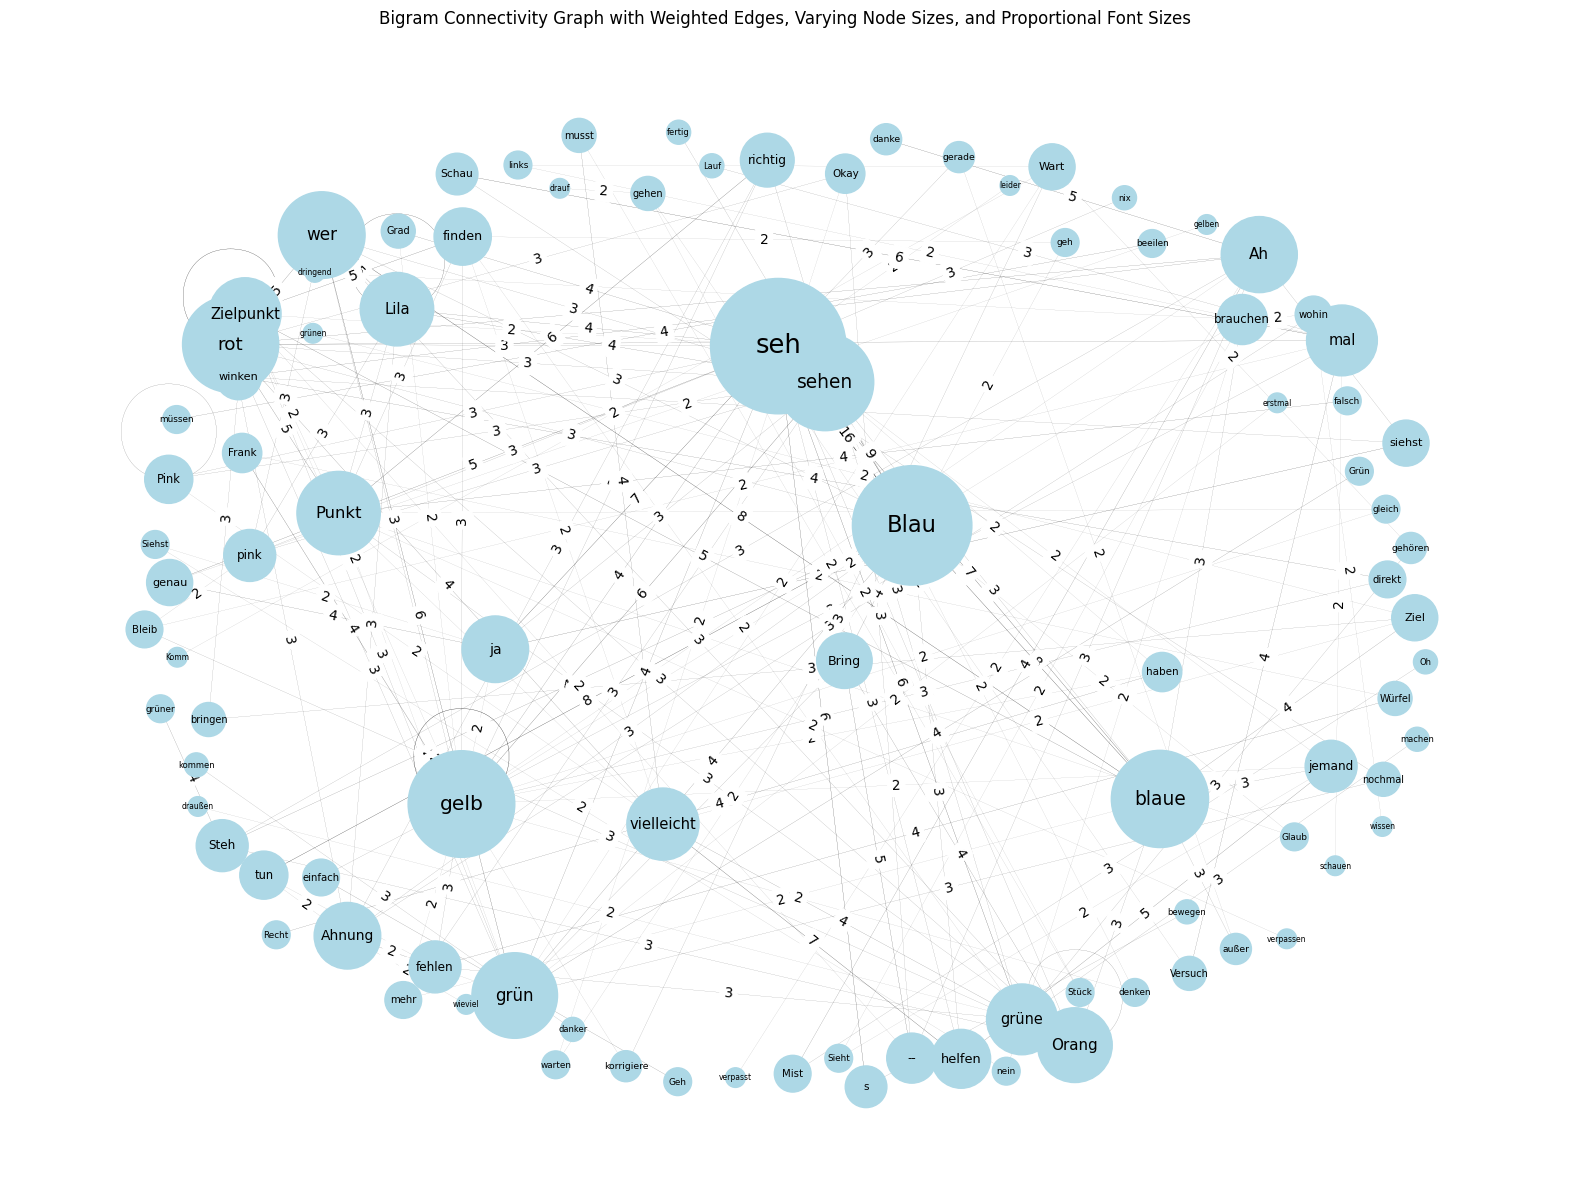

In [9]:
# Create a graph
G = nx.Graph()

bigram_tuples = [tuple(bigram) for bigram in bigrams_no_stopwords]

# Count frequencies of each bigram tuple
bigram_counts = Counter(bigram_tuples).most_common(200)
# Adding edges from the data
for (word1, word2), weight in bigram_counts:
    G.add_edge(word1, word2, weight=weight)

plt.figure(figsize=(20, 15))
# Position nodes using the spring layout
pos = nx.spring_layout(G, seed=42, k = 3)

# Calculate node sizes based on the sum of edge weights (scaled for visibility)
node_sizes = [sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()]
scaled_node_sizes = [size / 0.01 for size in node_sizes]  # Adjust size scale as needed

# Draw the nodes with increased size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=scaled_node_sizes)

# Draw the edges with varying width based on the weight
edge_widths = [G[u][v]['weight'] / 50 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths)

# Create a font size list based on node sizes (simple linear scaling)
font_sizes = [np.log(size)+0.05*size / 50 for size in scaled_node_sizes]  # Scale font size in relation to node size

# Draw labels for nodes with varying font sizes
for node, font_size in zip(G.nodes(), font_sizes):
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=font_size)

# Edge labels with weights
edge_labels = {(u, v): f'{d["weight"]}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.title("Bigram Connectivity Graph with Weighted Edges, Varying Node Sizes, and Proportional Font Sizes")
plt.axis('off')  # Turn off the axis
plt.show()

Nothing here either...
Before we start embedding, we want to check whether the model embeds the data as expected and preserves relatedness in meaning of words & sequences as measurable closeness in distance between these sequences.

In [10]:
#Let's start with some words
dog = get_embedding("Hund")
cat = get_embedding("Katze")
typically_german = get_embedding("Zahlungsverzug")

# Calculate the cosine similarity between the words
print(cosine_similarity(dog.reshape(1, -1), cat.reshape(1, -1)))
print(cosine_similarity(dog.reshape(1, -1), typically_german.reshape(1, -1)))
print(cosine_similarity(cat.reshape(1, -1), typically_german.reshape(1, -1)))
print("Words work as expected") #Side-Note: Cats are more likely to be behind on a payment than dogs as it seems hahahaha
print("")
# Calculate the cosine similarity between some sentences and do the same over again
sentence1 = get_embedding("Der Hund bellt.")
sentence2 = get_embedding("Die Katze schläft.")
sentence3 = get_embedding("Der Zahlungsverzug ist ein Problem.")

print(cosine_similarity(sentence1.reshape(1, -1), sentence2.reshape(1, -1)))
print(cosine_similarity(sentence1.reshape(1, -1), sentence3.reshape(1, -1)))
print(cosine_similarity(sentence2.reshape(1, -1), sentence3.reshape(1, -1)))
print("Sentences work as expected")


[[0.9038009]]
[[0.65881634]]
[[0.6671236]]
Words work as expected

[[0.8005184]]
[[0.53862524]]
[[0.53948593]]
Sentences work as expected


In [23]:

# Iterate through the DataFrame and get embeddings
word_embeddings_with_stopwords = word_level_frame_with_stopwords['Word'].apply(get_embedding)
word_embeddings_no_stopwords = word_level_frame_no_stopwords['Word'].apply(get_embedding)
sentence_embeddings = sentence_level_frame['Sentence'].apply(get_embedding)

wlf_sw = word_level_frame_with_stopwords.copy() #copy for later use
slf_sw = sentence_level_frame.copy() #copy for later use

# Create new columns for each embedding dimension
embedding_columns = [f"embedding_{i}" for i in range(384)]

#concat with frames
word_level_frame_with_stopwords[embedding_columns] = pd.DataFrame(word_embeddings_with_stopwords.tolist(), index=word_level_frame_with_stopwords.index)
sentence_level_frame[embedding_columns] = pd.DataFrame(sentence_embeddings.tolist(), index=sentence_level_frame.index)
word_level_frame_no_stopwords[embedding_columns] = pd.DataFrame(word_embeddings_no_stopwords.tolist(), index=word_level_frame_no_stopwords.index)

In [24]:
columns_to_standardize = word_level_frame_with_stopwords.columns[2:]

# Initialize StandardScaler
word_scaler_stopwords = StandardScaler()
word_scaler_no_stopwords = StandardScaler()
sentence_scaler = StandardScaler()

# Fit and transform only the sliced columns
word_level_frame_with_stopwords[columns_to_standardize] = word_scaler_stopwords.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])
word_level_frame_no_stopwords[columns_to_standardize] = word_scaler_no_stopwords.fit_transform(word_level_frame_no_stopwords[columns_to_standardize])
sentence_level_frame[columns_to_standardize] = sentence_scaler.fit_transform(sentence_level_frame[columns_to_standardize])

Lets start with PCA

In [13]:
pca_word = PCA(n_components=20) # Let's reduce the dimensionality to 20 just as an arbitrary choice
X20D_word = pca_word.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}") 

pca_sentence = PCA(n_components=20)
X20D_sentence = pca_sentence.fit_transform(sentence_level_frame[columns_to_standardize])
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.5980258584022522
Preserved variance for sentences is 0.5802032351493835


~58% is quite a lot for a reduction by a factor of almost 20!
But we will not get too much form increasing the dimensions much further, let's test with double the amount

In [14]:
pca_word = PCA(n_components=40) # Let's reduce the dimensionality to 20 just as an arbitrary choice
pca_word.fit(word_level_frame_with_stopwords[columns_to_standardize])
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}") 

pca_sentence = PCA(n_components=40)
pca_sentence.fit(sentence_level_frame[columns_to_standardize])
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.7802345752716064
Preserved variance for sentences is 0.757875382900238


40 dimensions is a lot though!Let's see how we do with 30

In [15]:
pca_word = PCA(n_components=30) # Let's reduce the dimensionality to 20 just as an arbitrary choice
X30D_word = StandardScaler().fit_transform(pca_word.fit_transform(word_level_frame_with_stopwords[columns_to_standardize])) # Standardize the data
print(f"Preserved variance for words is {np.sum(pca_word.explained_variance_ratio_)}")

pca_sentence = PCA(n_components=30)
X30D_sentence = StandardScaler().fit_transform(pca_sentence.fit_transform(sentence_level_frame[columns_to_standardize]))
print(f"Preserved variance for sentences is {np.sum(pca_sentence.explained_variance_ratio_)}")

Preserved variance for words is 0.7074577212333679
Preserved variance for sentences is 0.6862404942512512


This could be an acceptable number, but kmeans doesnt fare particularly well with high dimensional data
Another approach I would like to try is LDA, see beneath

![WhatsApp Image 2025-01-07 at 18.56.28_2bbf4117.jpg](<attachment:WhatsApp Image 2025-01-07 at 18.56.28_2bbf4117.jpg>)
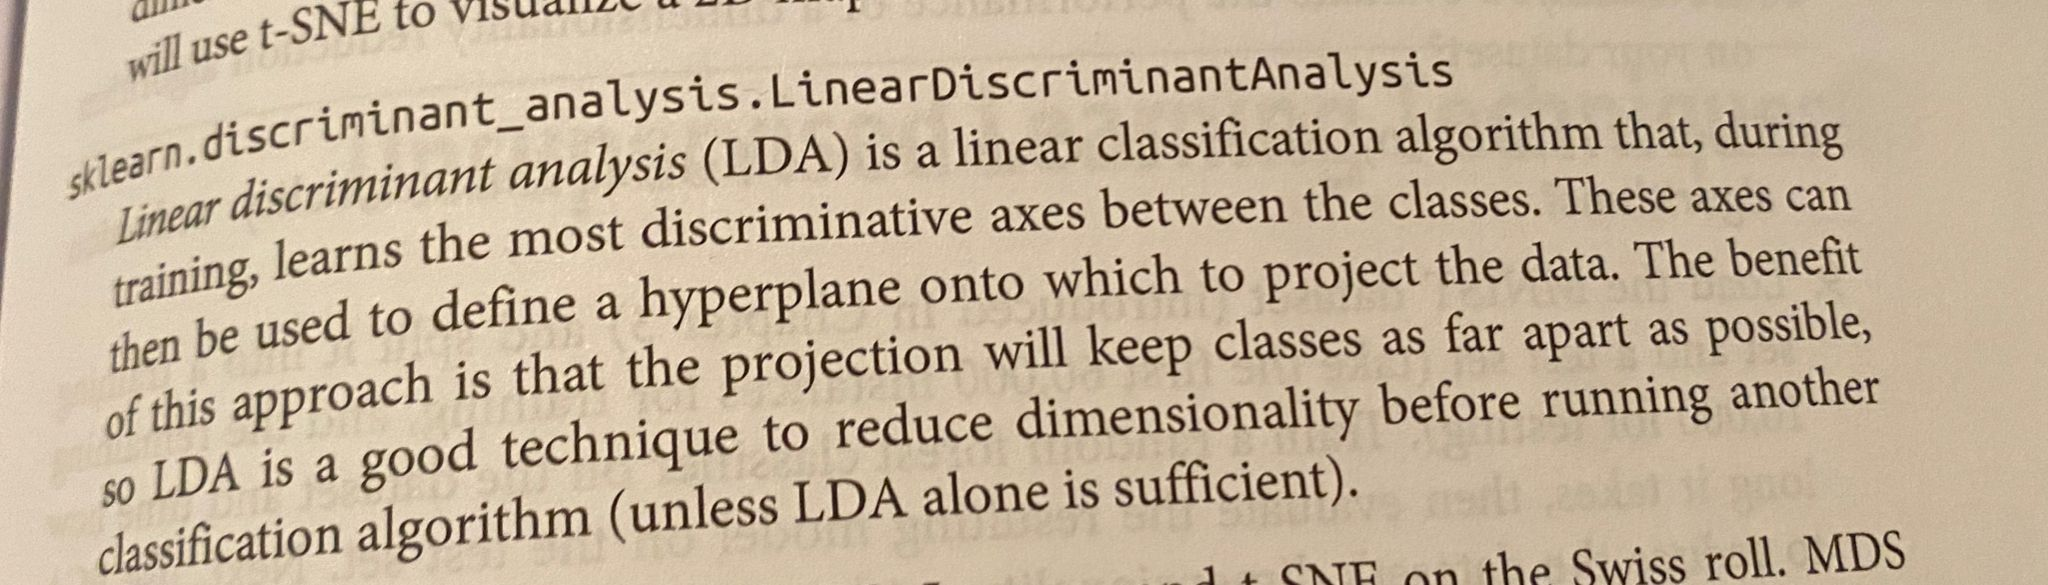

In [16]:
#following soon...maybe

A more sophisticated approach is the use of an Auto-Encoder architercture

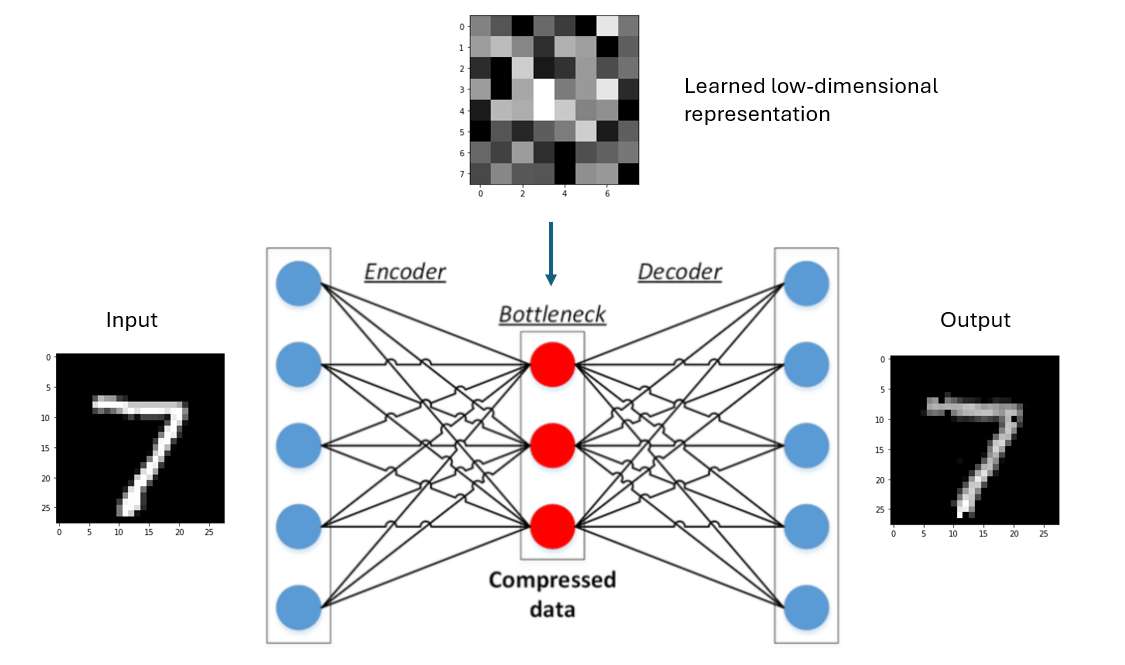 

In [17]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, input_size=384, latent_dim=3):
        super(Autoencoder, self).__init__()
         # Encoder with LayerNorm
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.LayerNorm(256),  # LayerNorm applied here
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),  # LayerNorm applied here
            nn.Linear(128, latent_dim)
        )
        
        # Decoder (could be symmetric or another design)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.LayerNorm(128),  # LayerNorm applied here
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.LayerNorm(256),  # LayerNorm applied here
            nn.Linear(256, input_size)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [18]:

def train_and_infer_encoder(data, dims=3, path="best_autoencoder.pth"):
    # Convert to PyTorch tensor
    X_tensor = torch.tensor(data[columns_to_standardize].values, dtype=torch.float32)

    # Create a DataLoader for batching
    dataset = TensorDataset(X_tensor)
    # Create train/validation split
    dataset = TensorDataset(X_tensor)
    train_size = int(0.8 * len(dataset))  # 80% for training
    val_size = len(dataset) - train_size  # 20% for validation
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Instantiate the encoder and move it to the GPU
    encoder = Autoencoder(latent_dim=dims).to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(encoder.parameters(), lr=0.001)

    # Early stopping and weight saving setup
    best_val_loss = float('inf')
    patience = 10  # Number of epochs to wait for improvement
    patience_counter = 0
    best_model_path = path


    # Training loop with early stopping
    epochs = 1000
    for epoch in range(epochs):
        encoder.train()  # Ensure the encoder is in training mode
        train_loss = 0.0
        for batch in train_loader:
            # Get input data and move to GPU
            batch_X = batch[0].to(device)

            # Forward pass
            outputs = encoder(batch_X)
            loss = criterion(outputs, batch_X)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)  # Average loss over training batches

        # Validation loop
        encoder.eval()  # Switch to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch_X = batch[0].to(device)
                outputs = encoder(batch_X)
                loss = criterion(outputs, batch_X)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)  # Average loss over validation batches

        # Check for improvement
        if val_loss < best_val_loss:
            print(f"Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving encoder...")
            best_val_loss = val_loss
            torch.save(encoder.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        # Early stopping
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    print("Training complete.")

    # Use the best encoder for inference
    loaded_model = Autoencoder(latent_dim=dims).to(device)
    loaded_model.load_state_dict(torch.load(best_model_path, weights_only=True))
    loaded_model.eval()  # Switch to evaluation mode
    print("Best encoder loaded.")

    #evaluate the model
    with torch.no_grad():
        # Using the entire dataset (X_tensor) for evaluation
        reconstructed_data = loaded_model(X_tensor.to(device))
        
        # Calculate the EVS for the best model
        evs = calculate_explained_variance_score(X_tensor, reconstructed_data)
        print(f"Explained Variance Score (EVS) for the Best Model: {evs:.4f}")

    # Example: Use the loaded encoder for inference
    with torch.no_grad():
        latent_representations = loaded_model.encoder(X_tensor.to(device)).cpu().numpy()
        print("Latent representations shape:", latent_representations.shape)
    return latent_representations

In [19]:
three_D_representations_word = train_and_infer_encoder(word_level_frame_with_stopwords[columns_to_standardize], dims=3) #model can be saved, but it is not necessary yet

Validation loss improved from inf to 0.6269. Saving encoder...
Epoch [1/1000] - Train Loss: 0.7545, Val Loss: 0.6269
Validation loss improved from 0.6269 to 0.5039. Saving encoder...
Epoch [2/1000] - Train Loss: 0.5343, Val Loss: 0.5039
Validation loss improved from 0.5039 to 0.4263. Saving encoder...
Epoch [3/1000] - Train Loss: 0.4359, Val Loss: 0.4263
Validation loss improved from 0.4263 to 0.3786. Saving encoder...
Epoch [4/1000] - Train Loss: 0.3723, Val Loss: 0.3786
Validation loss improved from 0.3786 to 0.3326. Saving encoder...
Epoch [5/1000] - Train Loss: 0.3259, Val Loss: 0.3326
Validation loss improved from 0.3326 to 0.2982. Saving encoder...
Epoch [6/1000] - Train Loss: 0.2929, Val Loss: 0.2982
Validation loss improved from 0.2982 to 0.2788. Saving encoder...
Epoch [7/1000] - Train Loss: 0.2590, Val Loss: 0.2788
Validation loss improved from 0.2788 to 0.2653. Saving encoder...
Epoch [8/1000] - Train Loss: 0.2466, Val Loss: 0.2653
Validation loss improved from 0.2653 to 0.2

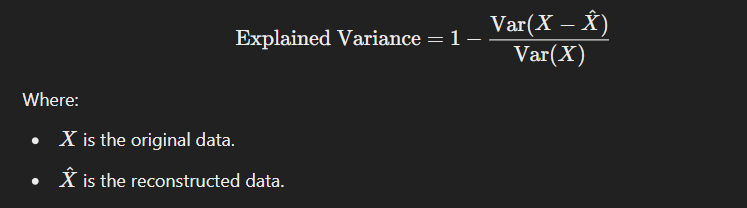

The information lost during encoding only accounts for 7% of the original variance!
Cool stuff 😎

In [20]:
#lets's still try with 10 dimensions, as well as with and without stopwords
ten_D_representations_word = train_and_infer_encoder(word_level_frame_with_stopwords[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.4038. Saving encoder...
Epoch [1/1000] - Train Loss: 0.6212, Val Loss: 0.4038
Validation loss improved from 0.4038 to 0.2818. Saving encoder...
Epoch [2/1000] - Train Loss: 0.3309, Val Loss: 0.2818
Validation loss improved from 0.2818 to 0.2216. Saving encoder...
Epoch [3/1000] - Train Loss: 0.2437, Val Loss: 0.2216
Validation loss improved from 0.2216 to 0.1868. Saving encoder...
Epoch [4/1000] - Train Loss: 0.1922, Val Loss: 0.1868
Validation loss improved from 0.1868 to 0.1614. Saving encoder...
Epoch [5/1000] - Train Loss: 0.1583, Val Loss: 0.1614
Validation loss improved from 0.1614 to 0.1452. Saving encoder...
Epoch [6/1000] - Train Loss: 0.1363, Val Loss: 0.1452
Validation loss improved from 0.1452 to 0.1310. Saving encoder...
Epoch [7/1000] - Train Loss: 0.1182, Val Loss: 0.1310
Validation loss improved from 0.1310 to 0.1217. Saving encoder...
Epoch [8/1000] - Train Loss: 0.1057, Val Loss: 0.1217
Validation loss improved from 0.1217 to 0.1

In [21]:
three_D_representations_word_no_stopwords = train_and_infer_encoder(word_level_frame_no_stopwords[columns_to_standardize], dims=3)

Validation loss improved from inf to 0.7608. Saving encoder...
Epoch [1/1000] - Train Loss: 0.9278, Val Loss: 0.7608
Validation loss improved from 0.7608 to 0.6254. Saving encoder...
Epoch [2/1000] - Train Loss: 0.6954, Val Loss: 0.6254
Validation loss improved from 0.6254 to 0.5572. Saving encoder...
Epoch [3/1000] - Train Loss: 0.5945, Val Loss: 0.5572
Validation loss improved from 0.5572 to 0.4987. Saving encoder...
Epoch [4/1000] - Train Loss: 0.5287, Val Loss: 0.4987
Validation loss improved from 0.4987 to 0.4646. Saving encoder...
Epoch [5/1000] - Train Loss: 0.4769, Val Loss: 0.4646
Validation loss improved from 0.4646 to 0.4336. Saving encoder...
Epoch [6/1000] - Train Loss: 0.4410, Val Loss: 0.4336
Validation loss improved from 0.4336 to 0.4106. Saving encoder...
Epoch [7/1000] - Train Loss: 0.4131, Val Loss: 0.4106
Validation loss improved from 0.4106 to 0.3905. Saving encoder...
Epoch [8/1000] - Train Loss: 0.3909, Val Loss: 0.3905
Validation loss improved from 0.3905 to 0.3

In [22]:
ten_D_representations_word_no_stopwords = train_and_infer_encoder(word_level_frame_no_stopwords[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.6053. Saving encoder...
Epoch [1/1000] - Train Loss: 0.8297, Val Loss: 0.6053
Validation loss improved from 0.6053 to 0.4427. Saving encoder...
Epoch [2/1000] - Train Loss: 0.5175, Val Loss: 0.4427
Validation loss improved from 0.4427 to 0.3588. Saving encoder...
Epoch [3/1000] - Train Loss: 0.3905, Val Loss: 0.3588
Validation loss improved from 0.3588 to 0.3097. Saving encoder...
Epoch [4/1000] - Train Loss: 0.3198, Val Loss: 0.3097
Validation loss improved from 0.3097 to 0.2753. Saving encoder...
Epoch [5/1000] - Train Loss: 0.2747, Val Loss: 0.2753
Validation loss improved from 0.2753 to 0.2499. Saving encoder...
Epoch [6/1000] - Train Loss: 0.2419, Val Loss: 0.2499
Validation loss improved from 0.2499 to 0.2256. Saving encoder...
Epoch [7/1000] - Train Loss: 0.2169, Val Loss: 0.2256
Validation loss improved from 0.2256 to 0.2094. Saving encoder...
Epoch [8/1000] - Train Loss: 0.1978, Val Loss: 0.2094
Validation loss improved from 0.2094 to 0.1

How about sentences?

In [23]:
three_D_representations_sentence = train_and_infer_encoder(sentence_level_frame[columns_to_standardize], dims=3)

Validation loss improved from inf to 0.9266. Saving encoder...
Epoch [1/1000] - Train Loss: 1.0578, Val Loss: 0.9266
Validation loss improved from 0.9266 to 0.8630. Saving encoder...
Epoch [2/1000] - Train Loss: 0.8943, Val Loss: 0.8630
Validation loss improved from 0.8630 to 0.8130. Saving encoder...
Epoch [3/1000] - Train Loss: 0.8344, Val Loss: 0.8130
Validation loss improved from 0.8130 to 0.7910. Saving encoder...
Epoch [4/1000] - Train Loss: 0.7989, Val Loss: 0.7910
Validation loss improved from 0.7910 to 0.7706. Saving encoder...
Epoch [5/1000] - Train Loss: 0.7708, Val Loss: 0.7706
Validation loss improved from 0.7706 to 0.7579. Saving encoder...
Epoch [6/1000] - Train Loss: 0.7485, Val Loss: 0.7579
Validation loss improved from 0.7579 to 0.7457. Saving encoder...
Epoch [7/1000] - Train Loss: 0.7269, Val Loss: 0.7457
Validation loss improved from 0.7457 to 0.7329. Saving encoder...
Epoch [8/1000] - Train Loss: 0.7095, Val Loss: 0.7329
Validation loss improved from 0.7329 to 0.7

Not too good, but let's still take a look at the compressed data later on

In [24]:
#choose 10D representation of the sentence instead
ten_D_representations_sentence =train_and_infer_encoder(sentence_level_frame[columns_to_standardize], dims=10)

Validation loss improved from inf to 0.8753. Saving encoder...
Epoch [1/1000] - Train Loss: 1.0532, Val Loss: 0.8753
Validation loss improved from 0.8753 to 0.7693. Saving encoder...
Epoch [2/1000] - Train Loss: 0.8021, Val Loss: 0.7693
Validation loss improved from 0.7693 to 0.7067. Saving encoder...
Epoch [3/1000] - Train Loss: 0.7001, Val Loss: 0.7067
Validation loss improved from 0.7067 to 0.6686. Saving encoder...
Epoch [4/1000] - Train Loss: 0.6371, Val Loss: 0.6686
Validation loss improved from 0.6686 to 0.6426. Saving encoder...
Epoch [5/1000] - Train Loss: 0.5930, Val Loss: 0.6426
Validation loss improved from 0.6426 to 0.6208. Saving encoder...
Epoch [6/1000] - Train Loss: 0.5598, Val Loss: 0.6208
Validation loss improved from 0.6208 to 0.6065. Saving encoder...
Epoch [7/1000] - Train Loss: 0.5320, Val Loss: 0.6065
Validation loss improved from 0.6065 to 0.5949. Saving encoder...
Epoch [8/1000] - Train Loss: 0.5071, Val Loss: 0.5949
Validation loss improved from 0.5949 to 0.5

Time for some clustering. Let's start with k-means

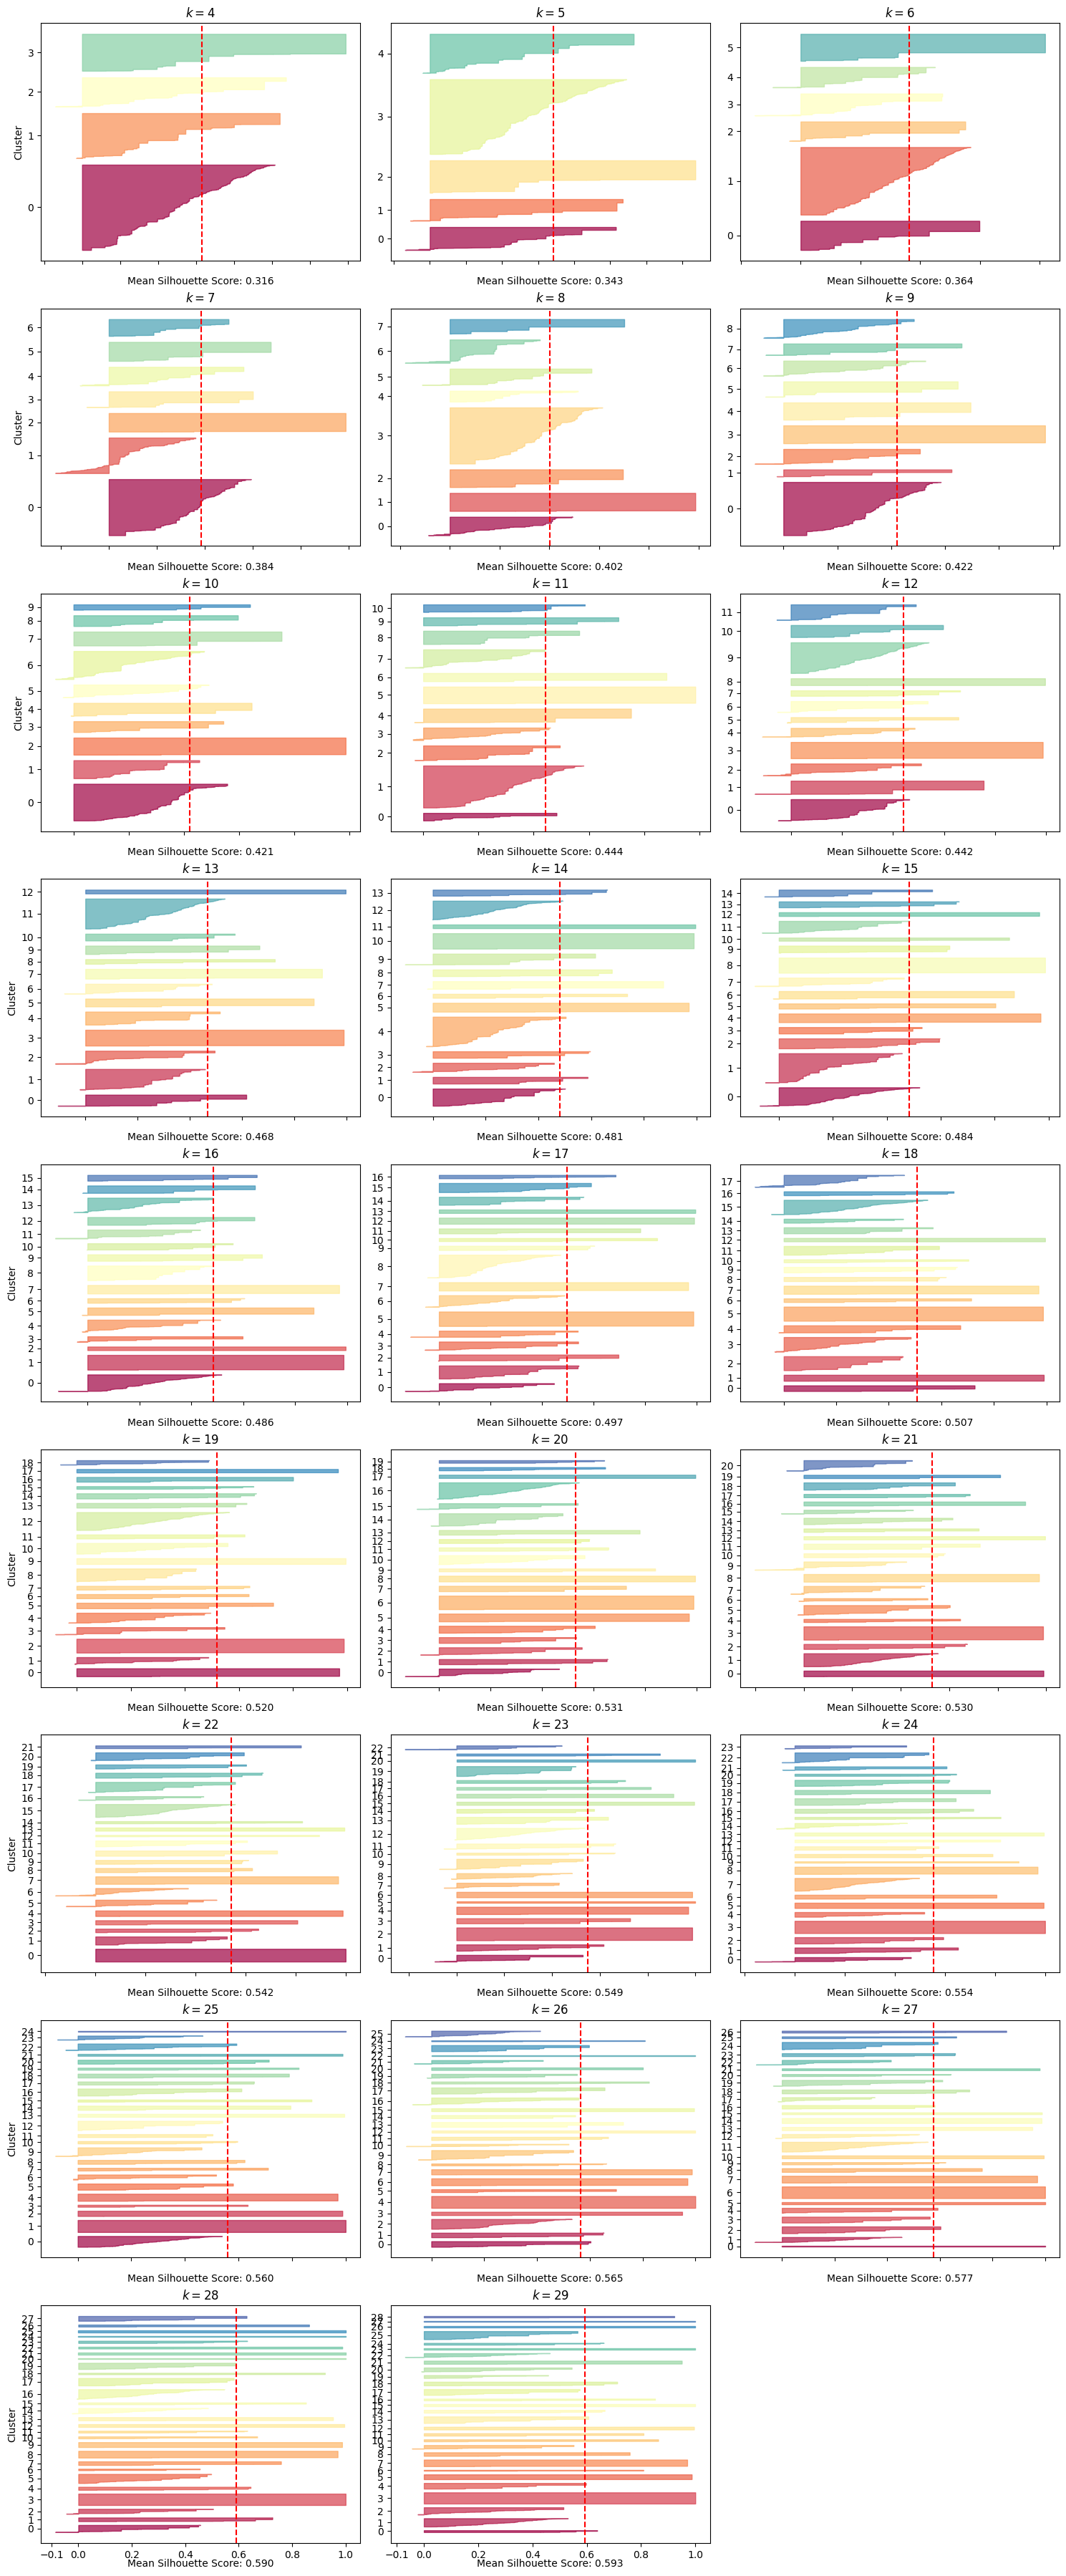

In [25]:
# A hyperparameter search for the best number of clusters
range_n_clusters = range(4, 30)  # Set the range of clusters you want to test
kmeans_per_k = [KMeans(n_clusters=k, n_init=40, random_state=42).fit(three_D_representations_word) for k in range_n_clusters]
silhouette_scores = [silhouette_score(three_D_representations_word, model.labels_) for model in kmeans_per_k]

# Define the range of k values to visualize
k_values = range_n_clusters  # Modify this range as needed

# Dynamically calculate the number of rows and columns for subplots
num_k = len(k_values)
num_cols = 3  # Set the number of columns you want
num_rows = (num_k + num_cols - 1) // num_cols  # Calculate rows to fit all k values

# Create the figure and adjust its size
plt.figure(figsize=(num_cols * 5, num_rows * 4))  # Increased overall plot size

# Loop through each k value and create a subplot
for idx, k in enumerate(k_values, start=1):
    plt.subplot(num_rows, num_cols, idx)
    
    # Predictions and silhouette coefficients
    y_pred = kmeans_per_k[k - 4].labels_  # Adjust index for kmeans_per_k
    silhouette_coefficients = silhouette_samples(three_D_representations_word, y_pred)

    # Plot silhouette coefficients for each cluster
    padding = len(three_D_representations_word) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    # Customize axes
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if idx % num_cols == 1:  # Label y-axis for the first column
        plt.ylabel("Cluster")
    
    if idx > (num_rows - 1) * num_cols:  # Label x-axis for the last row
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 4], color="red", linestyle="--")
    plt.title(f"$k={k}$")

    # Add mean silhouette score below the plot
    mean_score = silhouette_scores[k - 4]
    plt.text(0.5, -0.1, f"Mean Silhouette Score: {mean_score:.3f}",
             fontsize=10, ha="center", transform=plt.gca().transAxes)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


We will have to use other metrics instead!
The Calinski-Harabasz-Index (higher better) and Davies-Bouldin-Index (lower better) are both suited 

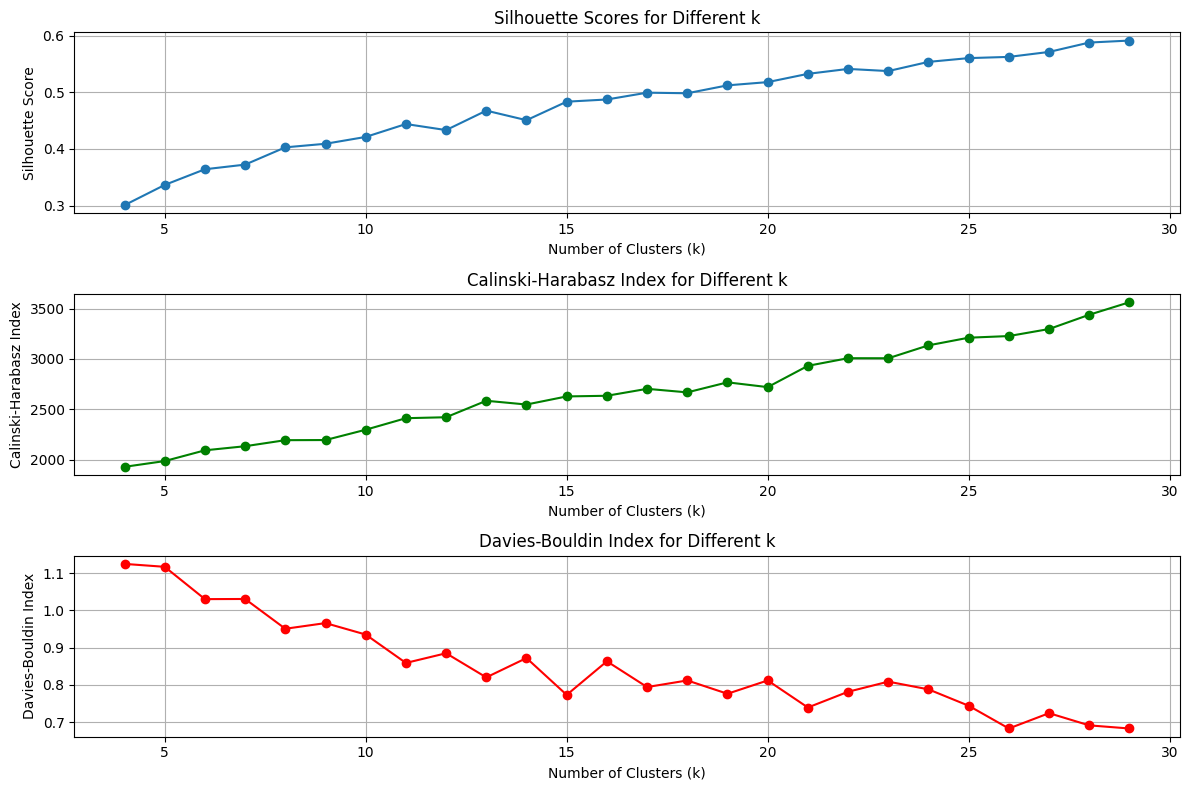

In [26]:
kmeans_ksearch_plots(three_D_representations_word)

It simply doesn't want to be clustered! We will revert to the most rudimentary methode: The ellbow

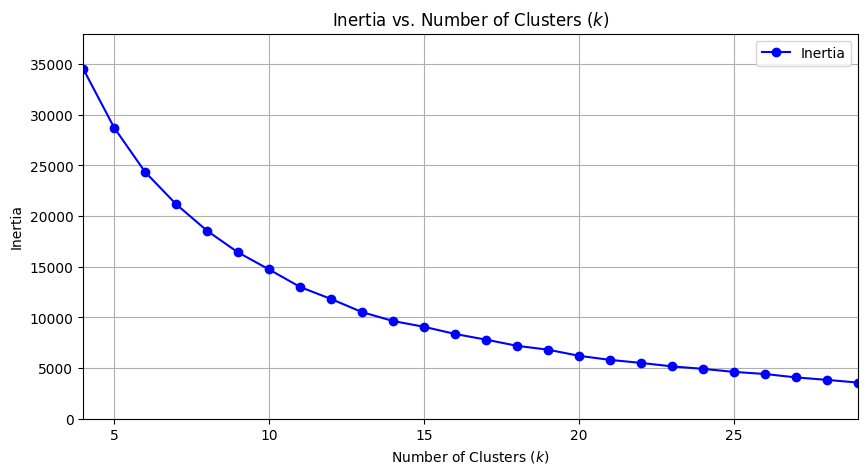

In [27]:
kmeans_ellbow_plot(three_D_representations_word)

With lots of fantasy there is an ellbow at 10
As the data is 3-D, we can just have a look...

In [28]:

def three_D_plot(data):
    # Create the figure
    fig = go.Figure()

    # Add scatter3d trace
    fig.add_trace(go.Scatter3d(
        x=data[:, 0],  # X coordinates
        y=data[:, 1],  # Y coordinates
        z=data[:, 2],  # Z coordinates
        mode='markers',
        marker=dict(
            size=5,  # Adjust size as needed
            opacity=0.05,  # Transparency
            color='blue'  # Optional, can be set to any color
        )
    ))

    # Set labels and layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X-axis',
            yaxis_title='Y-axis',
            zaxis_title='Z-axis'
        ),
        title='Interactive 3D Scatter Plot'
    )

    # Show the plot
    fig.show()
three_D_plot(three_D_representations_word)

Well, that explains a lot...
Let's check whether the dense center in the middle might be stopwords

In [29]:
three_D_plot(three_D_representations_word_no_stopwords)

Indeed! The center seems to be a lot less densly populated...fascinating
A potential approach to filtering might be to eliminate words close to the origin

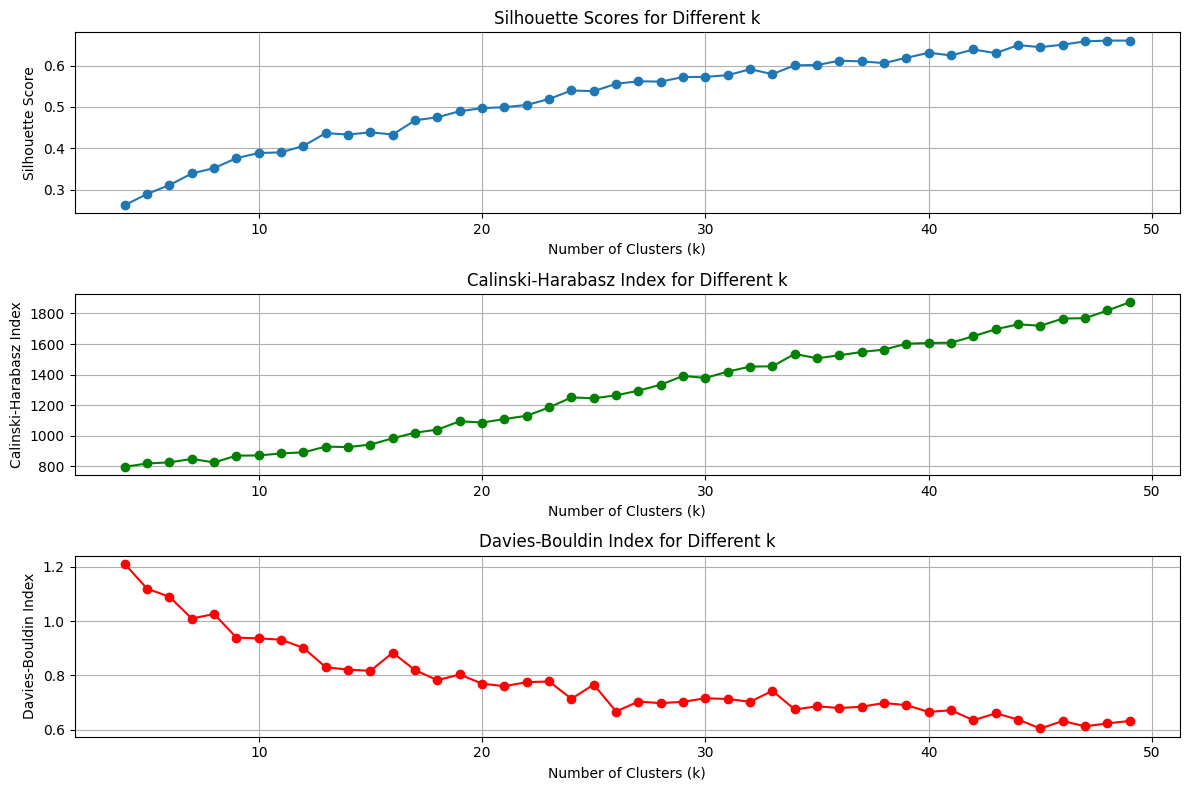

In [30]:
kmeans_ksearch_plots(three_D_representations_word_no_stopwords, k_range=range(4, 50))

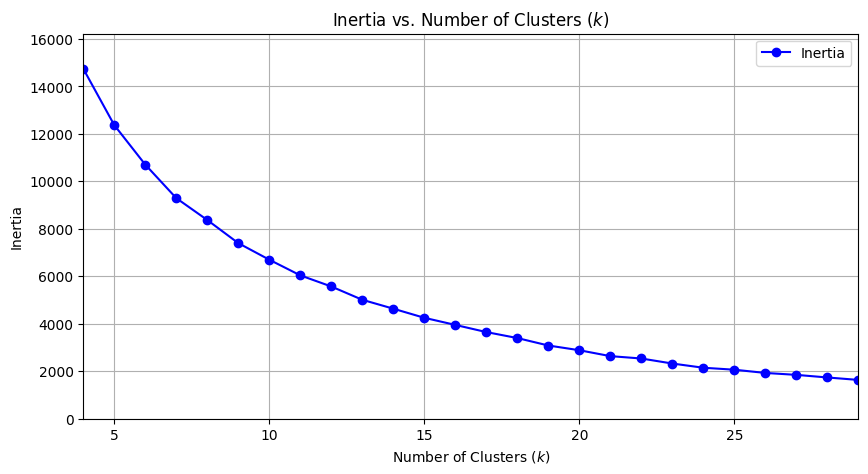

In [31]:
kmeans_ellbow_plot(three_D_representations_word_no_stopwords)

Not particularly clearer honestly. Let's try with less compressed data in 10-D

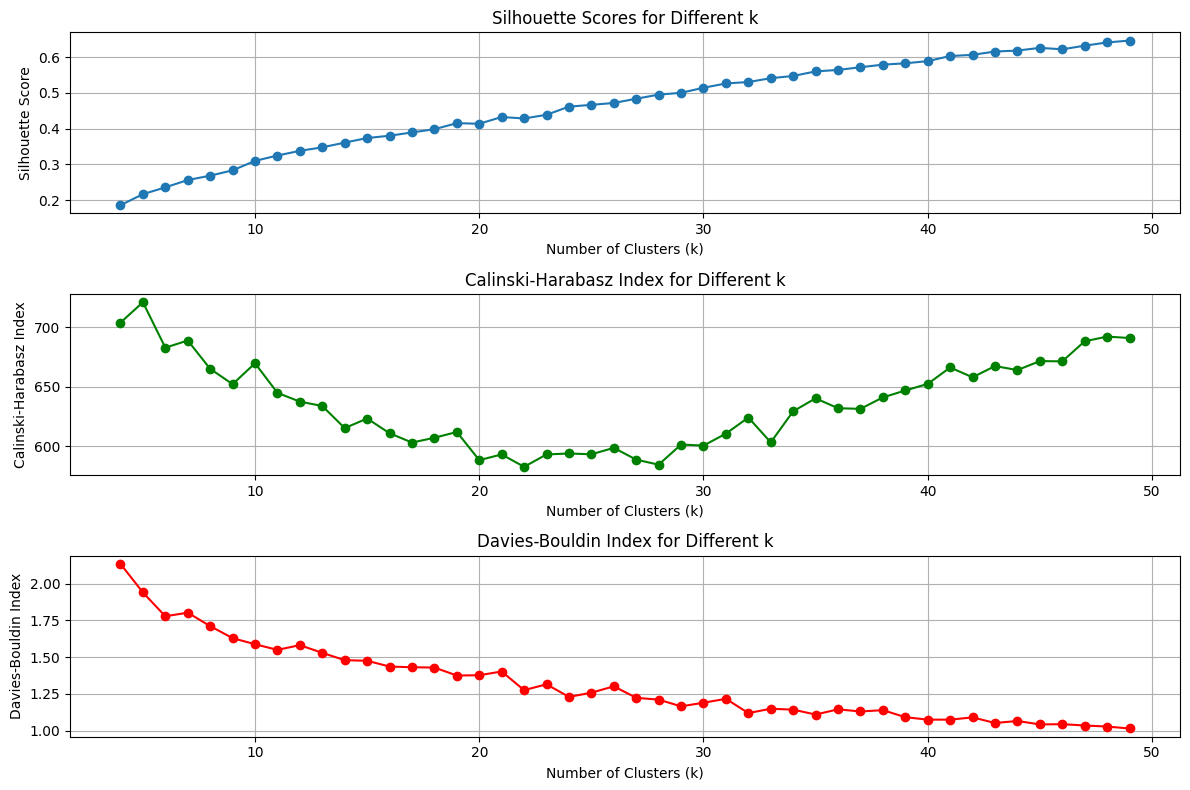

In [32]:
kmeans_ksearch_plots(ten_D_representations_word, k_range=range(4, 50))

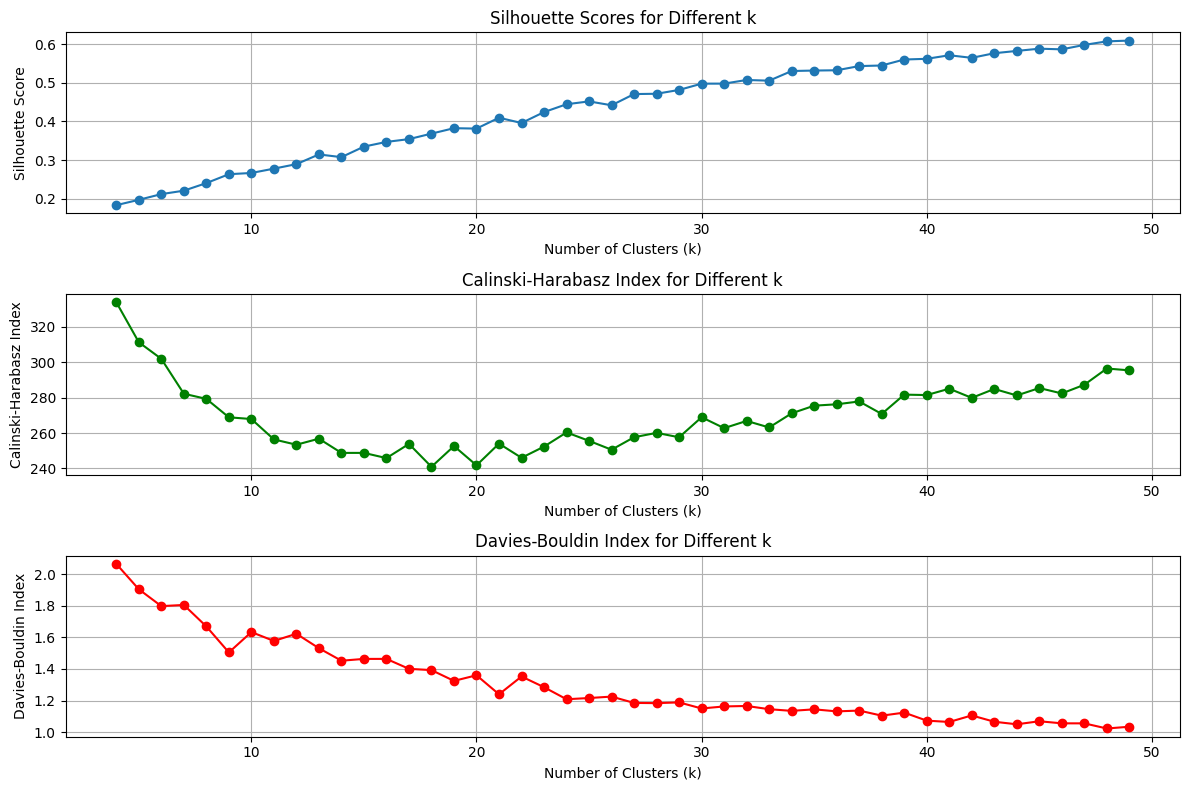

In [33]:
kmeans_ksearch_plots(ten_D_representations_word_no_stopwords, k_range=range(4, 50))

No improvement! The CHI starts behaving weirdly as well. 3 Dimensions seem to be working fine for our purpose.
Let's look at the sentence level

In [34]:
three_D_plot(three_D_representations_sentence)

Just homogenous goo...sadly

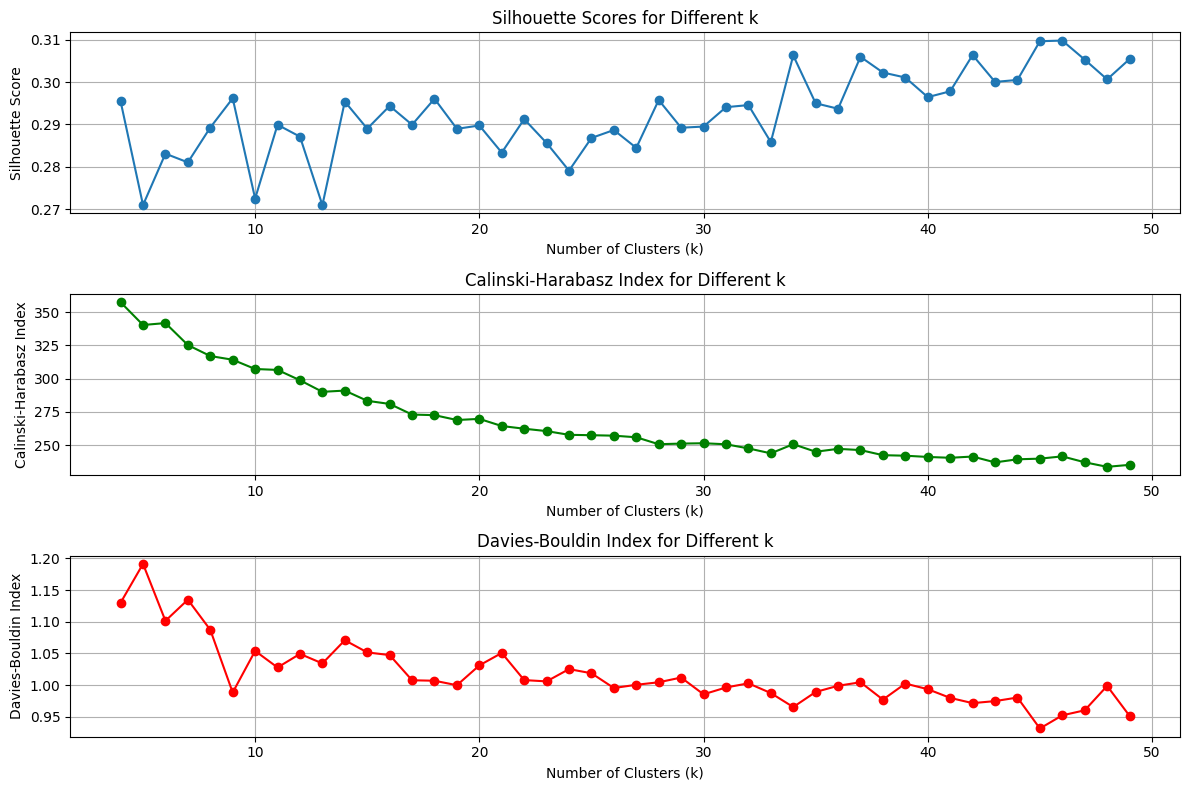

In [35]:
kmeans_ksearch_plots(three_D_representations_sentence, k_range=range(4, 50))

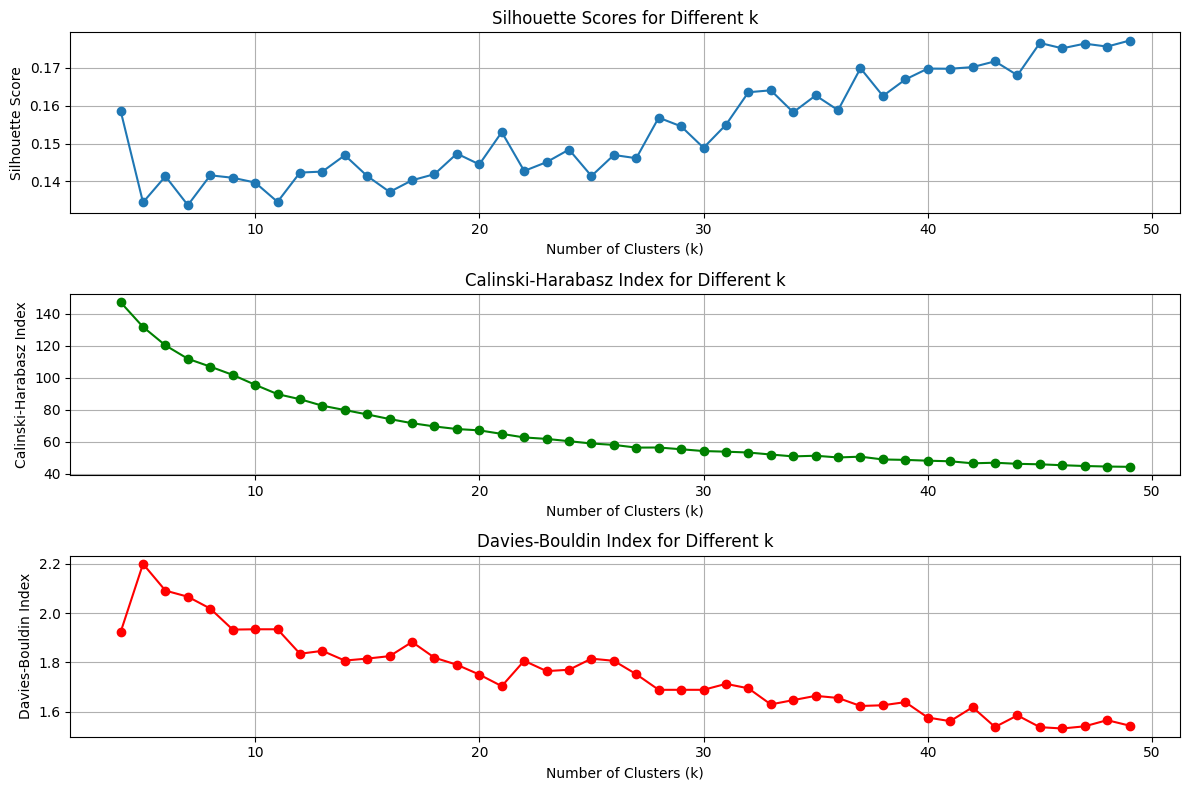

In [36]:
kmeans_ksearch_plots(ten_D_representations_sentence, k_range=range(4, 50))

It only get's worse with an increase in dimensions. The ellbow-plots were omitted, cause they look horrible. 

For sentence level data, there seem to be no distinct clusters in the data when compressed using an Autoencoder
Word level should definetly attempted, we will do a qualitative analysis later
We will try with PCA-compressed data

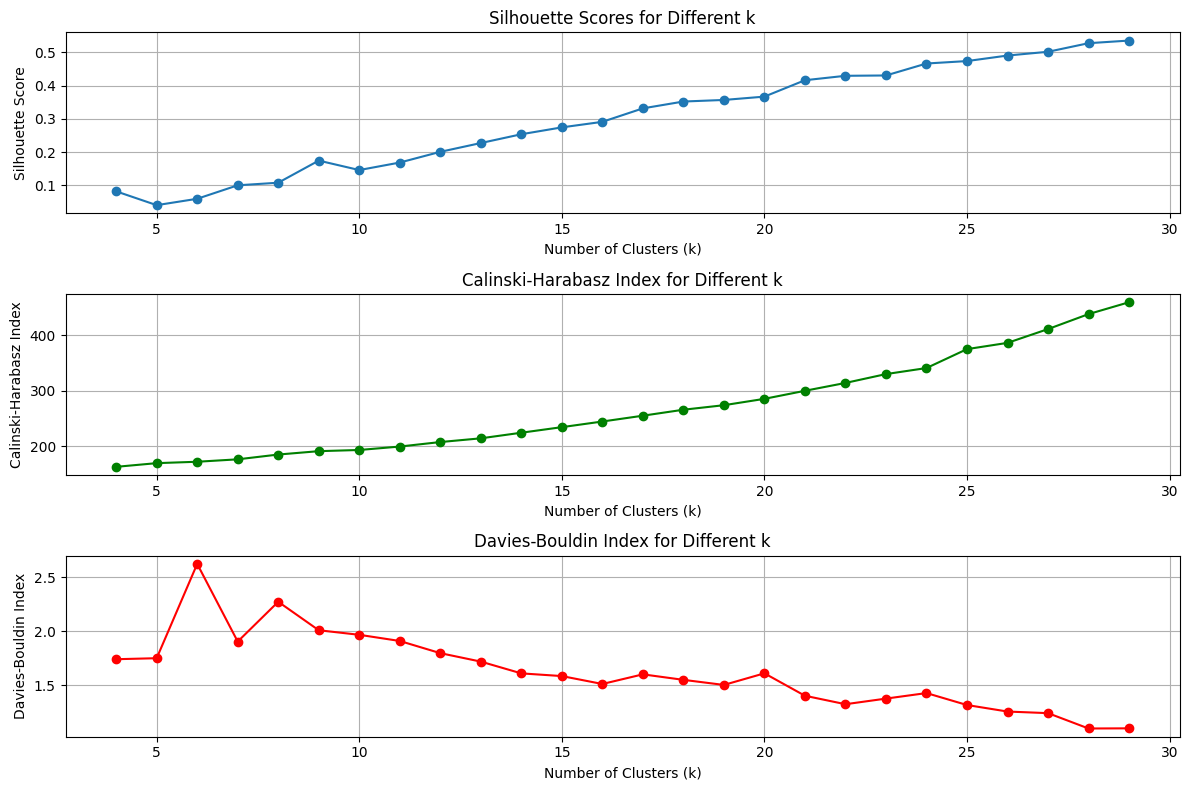

In [37]:
kmeans_ksearch_plots(X30D_word)

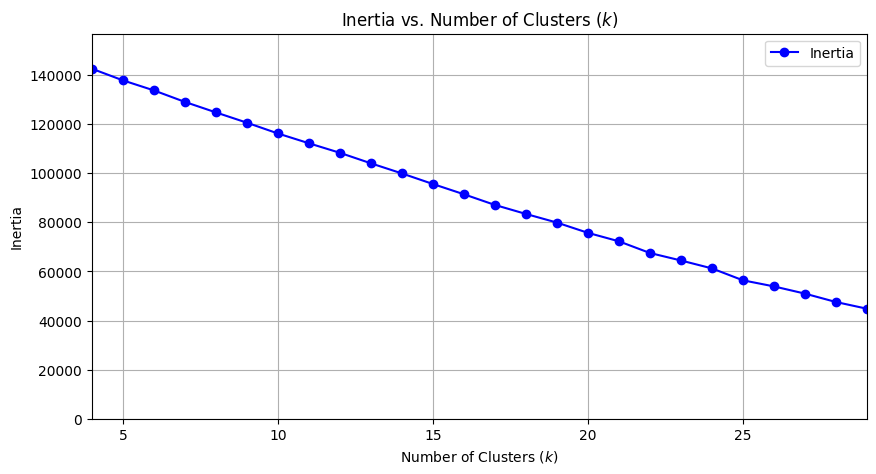

In [38]:
kmeans_ellbow_plot(X30D_word)

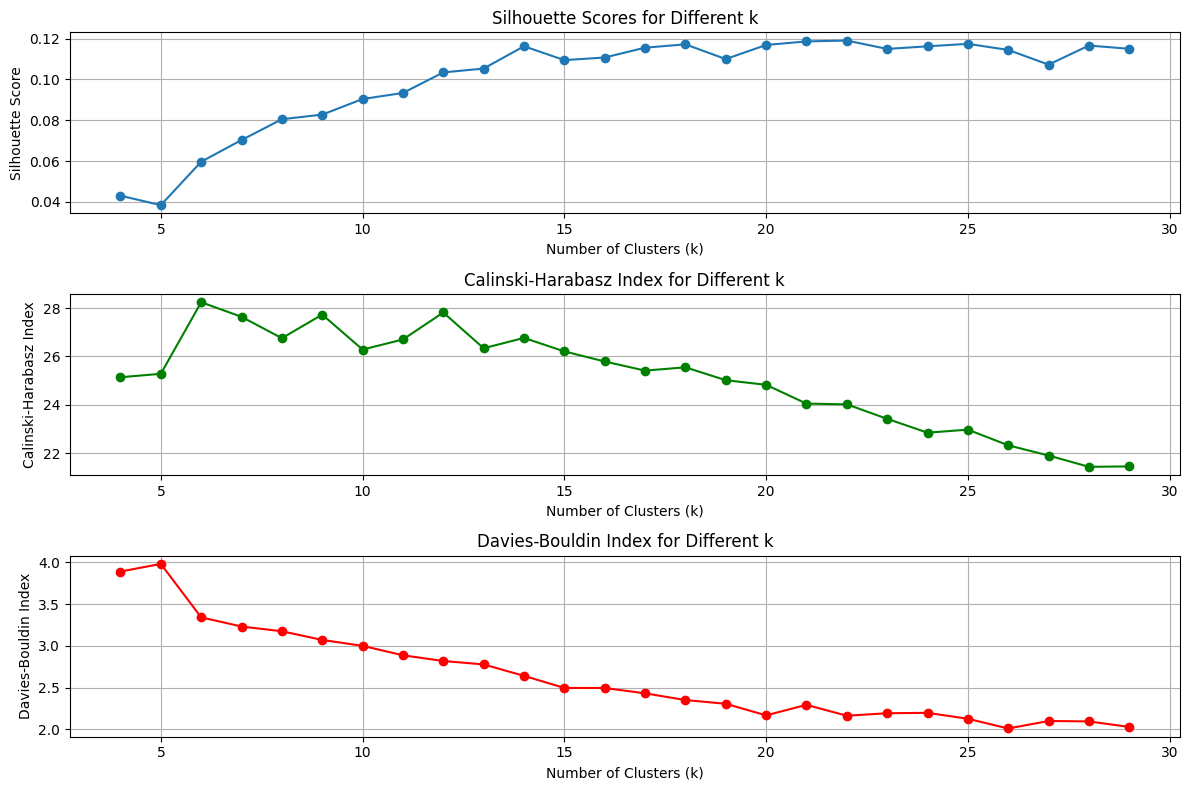

In [39]:
kmeans_ksearch_plots(X30D_sentence)

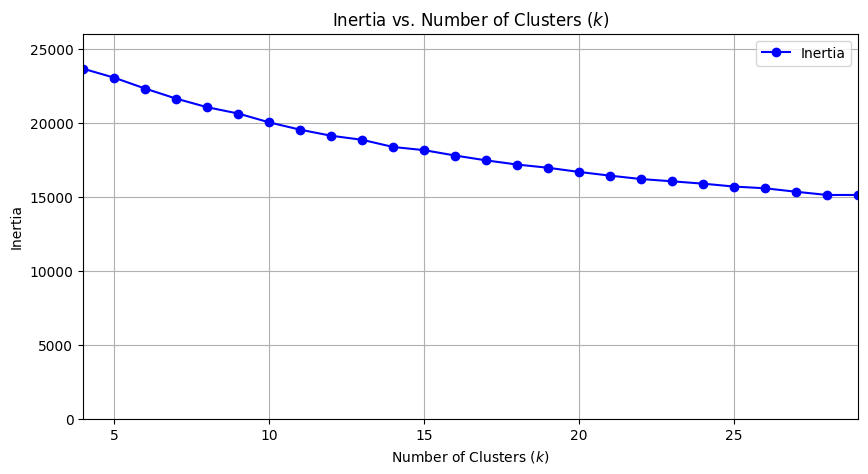

In [40]:
kmeans_ellbow_plot(X30D_sentence)

**Conclusion**: encoder-compressed data for words is worth a try and looks reasonably better.
10 Clusters for data including stopwords will be analyzed more closesly

We will now attempt 
* a qualitative evaluation of clustering
* filtering based on the distance to the origin
* Look at words that score high and low on our three dimensions

In [41]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, n_init=40, random_state=42).fit(three_D_representations_word)
wlf_sw['label'] = kmeans.labels_
wlf_sw[["dim_1","dim_2","dim_3"]] = pd.DataFrame(three_D_representations_word.tolist(), index=word_embeddings_with_stopwords.index)


# Retrieve cluster centers
cluster_centers = kmeans.cluster_centers_

# Assign distinct colors for each cluster
cluster_colors = [f'rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, 1.0)' 
                  for c in plt.cm.tab10(np.linspace(0, 1, n_clusters))]  # Full opacity for legend visibility
wlf_sw['color'] = wlf_sw['label'].apply(lambda x: f'rgba({int(plt.cm.tab10(x / n_clusters)[0] * 255)}, '
                                              f'{int(plt.cm.tab10(x / n_clusters)[1] * 255)}, '
                                              f'{int(plt.cm.tab10(x / n_clusters)[2] * 255)}, 0.7)')

# Create a 3D scatter plot
fig = go.Figure()

# Scatter plot for the data points
for i in range(n_clusters):
    cluster_data = wlf_sw[wlf_sw['label'] == i]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['dim_1'],
        y=cluster_data['dim_2'],
        z=cluster_data['dim_3'],
        mode='markers',
        marker=dict(size=4, color=cluster_colors[i], opacity=0.6),
        name=f'Cluster {i} Data'
    ))

# Scatter plot for the cluster centers with distinct colors
fig.add_trace(go.Scatter3d(
    x=cluster_centers[:, 0],
    y=cluster_centers[:, 1],
    z=cluster_centers[:, 2],
    mode='markers',
    marker=dict(size=7, color=cluster_colors, symbol='x', line=dict(width=2, color='black')),
    name='Cluster Centers'
))

# Update layout
fig.update_layout(
    title='3D Scatter Plot with KMeans Clusters',
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    legend=dict(itemsizing='constant'),
    width=1200,  # Set initial plot width
    height=800   # Set initial plot height
)

fig.show()

wlf_sw = wlf_sw.drop("color", axis=1)

Lets look at our top contenders for each cluster (e.g. the points closest to the centroids)

In [42]:

wlf_sw_uniques = wlf_sw.drop_duplicates(subset=["Word"])
# List to store closest points for each cluster
closest_points = []

# Iterate over each cluster
for i in range(n_clusters):
    # Get data points for the current cluster (filtered by 'label')
    cluster_data = wlf_sw_uniques[wlf_sw_uniques['label'] == i]
    
    # Compute the Euclidean distances from each data point to the current cluster center
    distances = cdist(cluster_data[['dim_1', 'dim_2', 'dim_3']], [kmeans.cluster_centers_[i]])
    
    # Get indices of the 10 closest points to the current cluster center
    closest_indices = np.argsort(distances.flatten())[:10]
    
    # Append the closest points to the list (use iloc to select by indices)
    closest_points.append(cluster_data.iloc[closest_indices])

# Combine the closest points from all clusters into a single DataFrame
closest_points_df = pd.concat(closest_points, ignore_index=True)

# Drop duplicate rows if any (just to be safe)
closest_points_df = closest_points_df.drop_duplicates()

# Display the resulting DataFrame with closest points
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
print(closest_points_df)

   Speaker          Word  label     dim_1     dim_2     dim_3
0       P2          alle      0  0.297212 -0.310183 -0.731029
1       P4         aller      0  0.292091 -0.226414 -0.743725
2       P5           ihr      0  0.478152 -0.067480 -0.202021
3       P1         immer      0  0.083163 -0.545601 -0.323446
4       P2         Leute      0  0.601523 -0.168212 -0.878901
5       P1      irgendwo      0  0.527433  0.168964 -0.669079
6       P5     Irgendwas      0  0.676241 -0.479836 -0.191700
7       P4     irgendwas      0  0.673866 -0.491924 -0.180934
8       P5        gleich      0 -0.168068 -0.133187 -0.595806
9       P5      woanders      0  0.537630  0.242732 -0.357450
10      P2          oder      1  0.139097 -0.789368  1.454001
11      P4            Oh      1 -0.119602 -0.029108  2.083635
12      P3            oh      1 -0.170699  0.021568  2.057688
13      P2            ob      1 -0.469449 -0.420530  1.349064
14      P4           rot      1  1.344740 -0.625487  1.354715
15      

Let's check my hunch earlier and look at the words closest to center, might they be irrelevant?

In [43]:
# Calculate the center (mean) of dim_1, dim_2, dim_3
center = wlf_sw_uniques[['dim_1', 'dim_2', 'dim_3']].mean()

# Calculate the Euclidean distances from each row to the center
distances = cdist(wlf_sw_uniques[['dim_1', 'dim_2', 'dim_3']], [center])

# Add the distances as a new column to the DataFrame
wlf_sw_uniques['Distance_to_Center'] = distances

# Sort the DataFrame by the 'Distance_to_Center' and select the closest 20 observations
closest_20 = wlf_sw_uniques[["Word","Distance_to_Center"]].nsmallest(20, 'Distance_to_Center').reset_index(drop=True)

# Display the resulting DataFrame with the 20 closest observations
print(closest_20)

           Word  Distance_to_Center
0          frei            0.079290
1          Herr            0.140747
2          spät            0.158732
3       dämlich            0.164418
4       solange            0.193732
5        leider            0.217984
6        drüben            0.246574
7   hoffentlich            0.250143
8        umdreh            0.292923
9           hol            0.294271
10     ziemlich            0.321089
11         dein            0.322508
12        ready            0.329291
13         Dreh            0.346770
14        Super            0.347447
15          nix            0.347761
16       mechen            0.373773
17        Frank            0.374258
18       drehen            0.385167
19          Bin            0.398537


And finally the words scoring highest among each of the three dimensions

In [44]:
# Sorting by each dimension and selecting the top 15 words
top_15_dim_1 = wlf_sw_uniques.nlargest(15, 'dim_1')[['Word', 'dim_1']].reset_index(drop=True)
top_15_dim_2 = wlf_sw_uniques.nlargest(15, 'dim_2')[['Word', 'dim_2']].reset_index(drop=True)
top_15_dim_3 = wlf_sw_uniques.nlargest(15, 'dim_3')[['Word', 'dim_3']].reset_index(drop=True)

# Display the results
print("Top 15 words for dim_1:")
print(top_15_dim_1)

print("\nTop 15 words for dim_2:")
print(top_15_dim_2)

print("\nTop 15 words for dim_3:")
print(top_15_dim_3)

Top 15 words for dim_1:
         Word     dim_1
0        Ziel  4.459614
1        sein  4.128693
2         ihn  4.055310
3   Zielpunkt  3.962510
4        sich  3.566323
5   erreichen  3.565119
6      werden  3.411941
7         der  3.269841
8         los  3.240809
9           s  2.796736
10      sehen  2.651551
11     Siehst  2.614511
12      Punkt  2.612706
13      Farbe  2.608716
14     siehst  2.595766

Top 15 words for dim_2:
          Word     dim_2
0     brauchen  5.182096
1       müssen  5.045068
2   brauchsten  4.920020
3      bringen  4.660866
4           zu  4.375670
5         Muss  4.290928
6        sehen  4.105200
7       Brauch  4.104167
8     sichtbar  4.045163
9        holen  4.025809
10       Bring  4.022705
11     gehören  3.982738
12       musst  3.951066
13         müs  3.727933
14    solltest  3.592381

Top 15 words for dim_3:
      Word     dim_3
0     Blau  5.295524
1     blau  5.170205
2    blaue  4.907756
3      seh  4.540700
4     pink  3.881944
5     Pink  3.83

In [45]:
#Let's see whether the 10 Dimensions form AEC encode more relevant information 
wlf_sw[["dim_1","dim_2","dim_3","dim_4","dim_5","dim_6","dim_7","dim_8","dim_9","dim_10"]] = pd.DataFrame(ten_D_representations_word.tolist(), index=word_embeddings_with_stopwords.index)
wlf_sw_uniques = wlf_sw.drop_duplicates(subset=["Word"])

# Sorting by each dimension and selecting the top 15 words
top_15_dims = {}

# Loop through dimensions 1 to 10
for i in range(1, 11):
    column_name = f'dim_{i}'
    top_15_dims[column_name] = wlf_sw_uniques.nlargest(15, column_name)[['Word', column_name]].reset_index(drop=True)

# Display the results
for i in range(1, 11):
    column_name = f'dim_{i}'
    print(f"\nTop 15 words for {column_name}:")
    print(top_15_dims[column_name])


Top 15 words for dim_1:
    Word     dim_1
0    ihn  3.143956
1   also  3.060603
2     er  2.957896
3     es  2.930339
4   auch  2.911528
5    ihr  2.662318
6      s  2.604163
7    und  2.401341
8    uns  2.280178
9    wir  2.235160
10   der  2.194573
11   ich  2.178668
12  mich  2.097595
13  dich  2.085356
14  eure  2.024157

Top 15 words for dim_2:
       Word     dim_2
0      Zeit  4.285899
1     schon  4.279691
2   Ssssehr  4.008293
3       Hab  3.961092
4      spät  3.819624
5   Sekunde  3.747387
6       Ahh  3.716748
7        so  3.705429
8      Such  3.695132
9     jetzt  3.564554
10       Äh  3.482567
11   sofort  3.465958
12       äh  3.340536
13      hol  3.277737
14     sein  3.254666

Top 15 words for dim_3:
       Word     dim_3
0      oder  4.987029
1        ob  4.967347
2      noch  4.769668
3     beide  4.590020
4      zwei  4.496158
5        ab  4.412474
6        oh  4.344085
7        Oh  4.290691
8     Nadia  4.254593
9       Ohh  4.207459
10       Ah  4.157495
11   

Nächster Ansatz: Faktorenanalyse um eine semantische Gemeinsamkeit aufrecht zu erhalten (durch Faktorenrotation)

In [49]:
pd.set_option('display.max_rows', 20) 
pd.set_option('display.max_columns', 10)
kmo_all, kmo_model = calculate_kmo(word_level_frame_with_stopwords.iloc[:,2:])
print(f"KMO Sampling Adequacy: {kmo_model}")

KMO Sampling Adequacy: 0.09302665562626579


Nevermind, Voraussetzung für eine Faktorenanalyse ist ein KMO von >.5
Dies deutet auch daraufhin dass PCA wenig Sinn macht allgemein

Nächster Ansatz: Synchronisierung im Team für Sentiment Scores o.Ä berechnen

In [15]:
client = OpenAI(base_url="http://127.0.0.1:1234/v1", api_key="lm-studio") #API

system_prompt =  "Rate the sentiment of the supplied user prompt which is in German. The sentiment rating score should be continous and range from -1 (negative sentiment) to 1 (positive sentiment). The sentiment score should be based on the user's sentiment in the prompt and nothing else. Do not answer with anything other than the sentiment score. Only answer with this single digit score. Do not output an explanation or any form of text, just supply the score."  
user_prompt_stable = "Rate the sentiment of the supplied prompt after the colon. The prompt is in German. The sentiment rating score should be continous and range from -1 (negative sentiment) to 1 (positive sentiment). Do not answer with anything other than the score. Do not output an explanation or any form of text, just supply the score. The prompt is: "

#
def remove_cot(text):
    try:
        return float(re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)) #The Deep Seek R1 model outputs CoT indicated by <think> tags
    except ValueError:
        return float('nan')


#Query the model
def prompt_model(prompt):
    completion = client.chat.completions.create(
        model="deepseek-r1-distill-qwen-7b:2",
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {"role": "user", "content": user_prompt_stable + str(prompt)},
        ],
        temperature=0,
    )
    return remove_cot(completion.choices[0].message.content)

# Working in bigger batches with progress feedback
def batch_prompt_model(prompts, mode="normal"):
    results = []
    for p in prompts:
        if mode == "normal":
            results.append(prompt_model(p))
        elif mode == "RAG":
            results.append(RAG_prompt_model(p)) #functionality leftover from earlier iteration, not used here but kept in case needed
        else:
            raise ValueError(f"Invalid mode '{mode}'.")
        if len(results) % 20 == 0:
            print(f"Completed {len(results)} prompts.")
    return results


In [30]:
sentence_level_frame = sentence_level_frame[["Speaker", "Sentence"]]
sentence_level_frame["Senti_Score"] = batch_prompt_model(sentence_level_frame["Sentence"].values)


Completed 20 prompts.
Completed 40 prompts.
Completed 60 prompts.
Completed 80 prompts.
Completed 100 prompts.
Completed 120 prompts.
Completed 140 prompts.
Completed 160 prompts.
Completed 180 prompts.
Completed 200 prompts.
Completed 220 prompts.
Completed 240 prompts.
Completed 260 prompts.
Completed 280 prompts.
Completed 300 prompts.
Completed 320 prompts.
Completed 340 prompts.
Completed 360 prompts.
Completed 380 prompts.
Completed 400 prompts.
Completed 420 prompts.
Completed 440 prompts.
Completed 460 prompts.
Completed 480 prompts.
Completed 500 prompts.
Completed 520 prompts.
Completed 540 prompts.
Completed 560 prompts.
Completed 580 prompts.
Completed 600 prompts.
Completed 620 prompts.
Completed 640 prompts.
Completed 660 prompts.
Completed 680 prompts.
Completed 700 prompts.
Completed 720 prompts.
Completed 740 prompts.
Completed 760 prompts.
Completed 780 prompts.
Completed 800 prompts.
Completed 820 prompts.
Completed 840 prompts.
Completed 860 prompts.


In [31]:
sentence_level_frame.to_csv("sentence_level_frame.csv", index=False)
sentence_level_frame

Speaker                                           Sentence Senti_Score
0        P1                                      Wer ist Pink?           0
1        P2                                   Bin beschäftigt!           0
2        P1  Okay, dann warte ich erstmal, ich bin bei dem ...           0
3        P3  Und wenn du wieder, wenn du wieder rein kommst...         0.8
4        P2                               Wie war, wo war der?           0
..      ...                                                ...         ...
861      P5                                       Wie wo bist.           0
862      P1                                     Drin bei Lila.         0.8
863      P4  Ich hab hier nochn Blauen gerade wenn du ferti...           0
864      P3                                                Ja?           1
865      P4                            Wenn du rechts schaust.           0

[866 rows x 3 columns]

Diese Scorings sehen aber makaber aus!
Wir probieren noch ein anderes Model, welches auf Tweets trainiert wurde

In [63]:
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

def continuous_sentiment(text):
    results = classifier(text, return_all_scores=True)[0]  # Get confidence scores
    
    # Compute weighted sum of star ratings (1 to 5)
    weighted_sum = sum(int(sent['label'][0]) * sent['score'] for sent in results)
    
    # Normalize to range [-1, 1]
    return np.round((weighted_sum - 3) / 2, 1)

def continuous_sentiment_batch(texts):
    sentiment_scores = []
    
    for text in texts:
        result = continuous_sentiment(text)
        sentiment_scores.append(result)
    
    return sentiment_scores


Device set to use cuda:0


In [64]:
texts = [
    "Ich bin sehr glücklich.",  # Positive
    "Es ist okay.",  # Neutral
    "Das war wirklich schlecht.",  # Negative
    "Die Würfel? Keine Ahnung mann", # eher negativ
    "Ich hab was gefunden! Ja das ist deine Farbe!" #eher positiv   
]

for text in texts:
    score = continuous_sentiment(text)
    print(f"Text: {text}\nSentiment Score: {score:.4f}\n")

Text: Ich bin sehr glücklich.
Sentiment Score: 0.9000

Text: Es ist okay.
Sentiment Score: 0.1000

Text: Das war wirklich schlecht.
Sentiment Score: -0.8000

Text: Die Würfel? Keine Ahnung mann
Sentiment Score: -0.3000

Text: Ich hab was gefunden! Ja das ist deine Farbe!
Sentiment Score: 0.7000



Sieht tatsächlich viel besser aus!

In [65]:
sentence_level_frame = sentence_level_frame.rename(columns={"Senti_Score": "Senti_Score_R1"})
sentence_level_frame["Senti_Score_BERT"] = continuous_sentiment_batch(sentence_level_frame["Sentence"].values)

Tatsächlich sind aber ja all unsere Skripte hier zusammengefügt worden. Wir schauen uns jetzt stattdessen isoliert das tatsächlich transkibierte Szenerio an

In [118]:
#Create time series
sentence_level_frame_last_szenario = sentence_level_frame[-78:].reset_index(drop=True)  
# Initialize variables to store the last sentiment for each speaker
last_sentiments = {'P1': [0, 0], 'P2': [0, 0], 'P3': [0, 0], 'P4': [0, 0], 'P5': [0, 0]}

# Prepare a new dataframe to store the results
output = []

# Iterate through the original dataframe
for _, row in sentence_level_frame_last_szenario.iterrows():
    speaker = row['Speaker']
    # Update the sentiment for the current speaker
    senti_r1 = row['Senti_Score_R1']
    senti_bert = row['Senti_Score_BERT']
    
    # Update the last sentiment for the current speaker
    last_sentiments[speaker] = [senti_r1, senti_bert]
    
    # For each timestep, get the sentiments for all speakers
    output_row = {
        'Senti_Score_R1_P1': last_sentiments['P1'][0],
        'Senti_Score_BERT_P1': last_sentiments['P1'][1],
        'Senti_Score_R1_P2': last_sentiments['P2'][0],
        'Senti_Score_BERT_P2': last_sentiments['P2'][1],
        'Senti_Score_R1_P3': last_sentiments['P3'][0],
        'Senti_Score_BERT_P3': last_sentiments['P3'][1],
        'Senti_Score_R1_P4': last_sentiments['P4'][0],
        'Senti_Score_BERT_P4': last_sentiments['P4'][1],
        'Senti_Score_R1_P5': last_sentiments['P5'][0],
        'Senti_Score_BERT_P5': last_sentiments['P5'][1],
    }
    
    # Append this row to the output
    output.append(output_row)

# Convert the output into a DataFrame
ts_df = pd.DataFrame(output)


In [115]:
ts_df.describe()

Senti_Score_BERT_P1  Senti_Score_BERT_P2  Senti_Score_BERT_P3  \
count            78.000000            78.000000            78.000000   
mean             -0.021795             0.397436            -0.225641   
std               0.302650             0.356379             0.287595   
min              -0.400000            -0.400000            -0.900000   
25%              -0.200000             0.300000            -0.475000   
50%              -0.100000             0.500000            -0.200000   
75%               0.100000             0.700000            -0.000000   
max               0.800000             0.800000             0.200000   

       Senti_Score_BERT_P4  Senti_Score_BERT_P5  
count            78.000000            78.000000  
mean             -0.039744             0.152564  
std               0.215225             0.364219  
min              -0.400000            -0.300000  
25%              -0.200000            -0.200000  
50%               0.000000             0.000000  
75%               0.100000             0.500000  
max               0.800000             0.700000

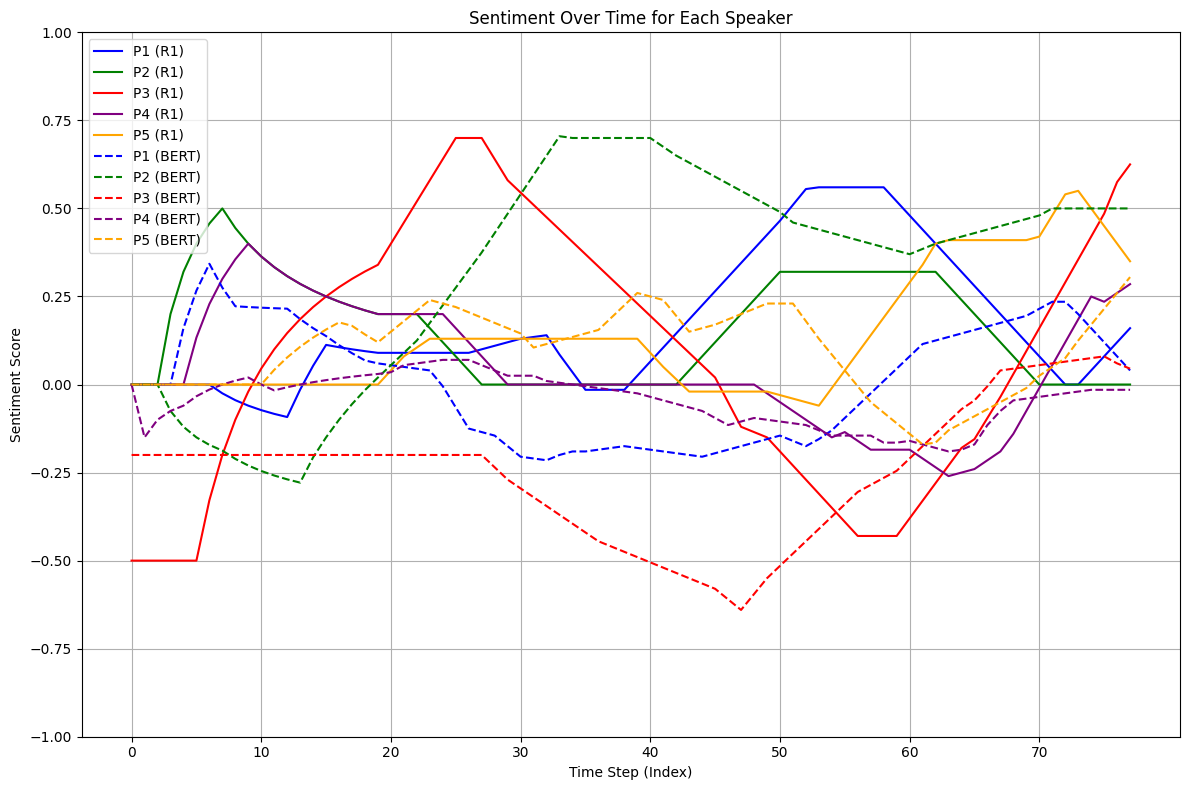

In [125]:
for col in ts_df.columns:
    ts_df[col] = ts_df[col].astype(float)

rolling_window = 20  # Smooths over the last 10 timesteps

# Apply rolling mean (only past values, not centered)
ts_df_smoothed = ts_df.rolling(window=rolling_window, min_periods=1).mean()

# Assuming your dataframe is already loaded as 'ts_df'
# Extract the time steps (index of the dataframe)
time_steps = ts_df_smoothed.index

# Plot the sentiment for each speaker and model
plt.figure(figsize=(12, 8))

# Plot R1 Sentiment for each speaker
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P1'], label='P1 (R1)', linestyle='-', color='blue')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P2'], label='P2 (R1)', linestyle='-', color='green')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P3'], label='P3 (R1)', linestyle='-', color='red')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P4'], label='P4 (R1)', linestyle='-', color='purple')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P5'], label='P5 (R1)', linestyle='-', color='orange')

# Plot BERT Sentiment for each speaker
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P1'], label='P1 (BERT)', linestyle='--', color='blue')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P2'], label='P2 (BERT)', linestyle='--', color='green')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P3'], label='P3 (BERT)', linestyle='--', color='red')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P4'], label='P4 (BERT)', linestyle='--', color='purple')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P5'], label='P5 (BERT)', linestyle='--', color='orange')

# Customize the plot
plt.title('Sentiment Over Time for Each Speaker')
plt.xlabel('Time Step (Index)')
plt.ylabel('Sentiment Score')

# Set the y-axis range to [-1, 1]
plt.ylim(-1, 1)

# Only show certain timesteps on the x-axis (every 100th timestep)
plt.xticks(range(0, len(time_steps), 10))

# Add grid lines for better readability
plt.grid(True)

# Show the legend
plt.legend(loc='upper left')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


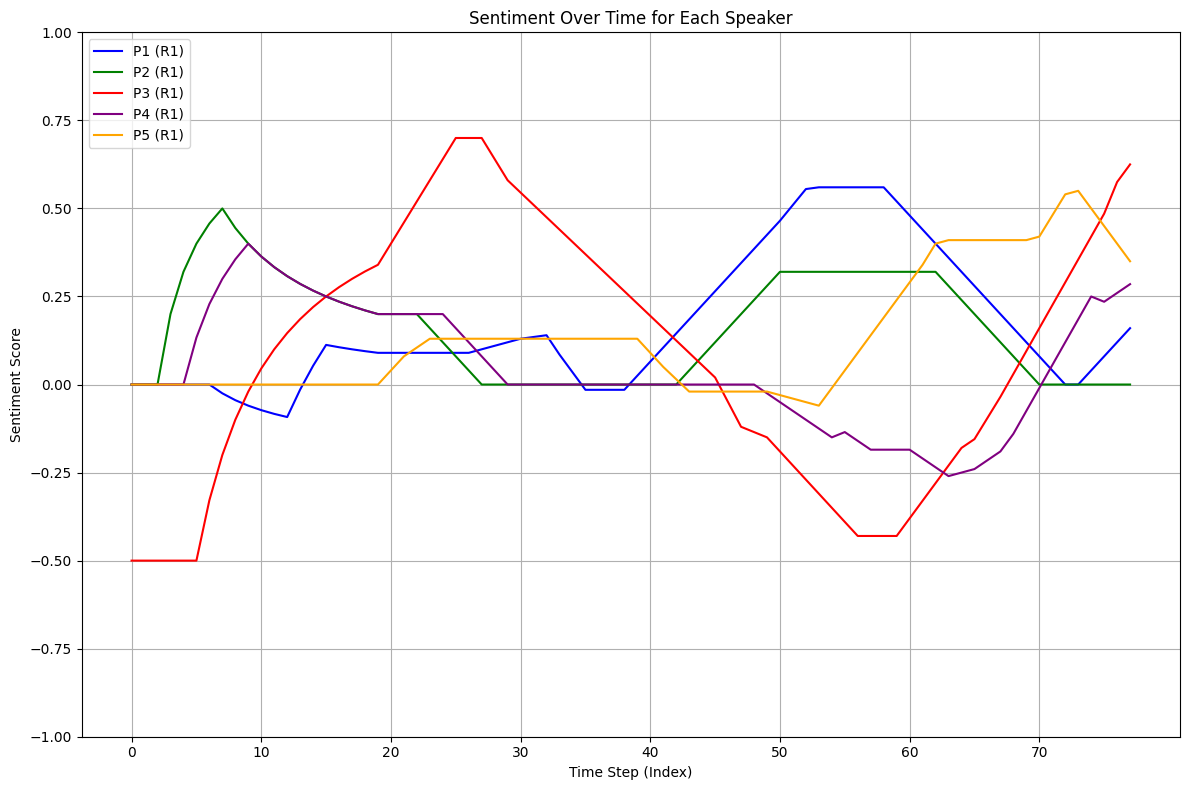

In [126]:
# Plot the sentiment for each speaker and model
plt.figure(figsize=(12, 8))

# Plot R1 Sentiment for each speaker
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P1'], label='P1 (R1)', linestyle='-', color='blue')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P2'], label='P2 (R1)', linestyle='-', color='green')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P3'], label='P3 (R1)', linestyle='-', color='red')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P4'], label='P4 (R1)', linestyle='-', color='purple')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_R1_P5'], label='P5 (R1)', linestyle='-', color='orange')

# Customize the plot
plt.title('Sentiment Over Time for Each Speaker')
plt.xlabel('Time Step (Index)')
plt.ylabel('Sentiment Score')

# Set the y-axis range to [-1, 1]
plt.ylim(-1, 1)

# Only show certain timesteps on the x-axis (every 100th timestep)
plt.xticks(range(0, len(time_steps), 10))

# Add grid lines for better readability
plt.grid(True)

# Show the legend
plt.legend(loc='upper left')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


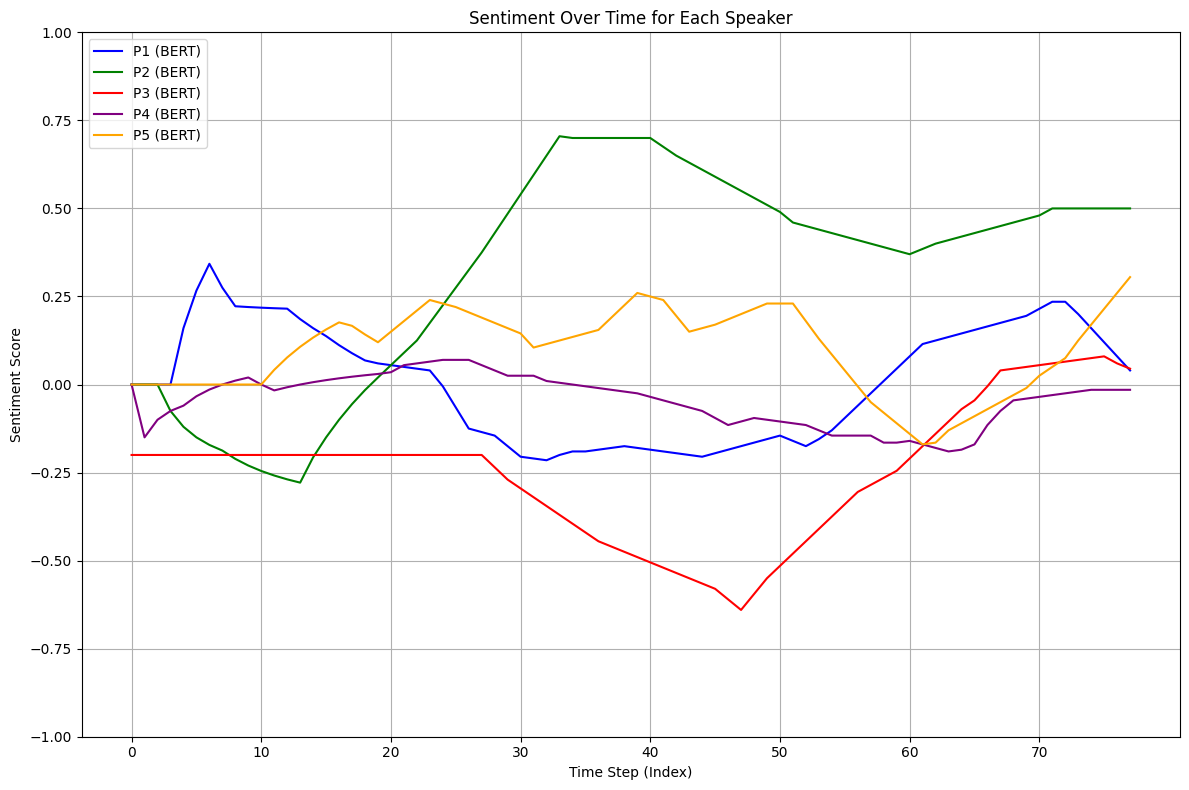

In [127]:
# Plot the sentiment for each speaker and model
plt.figure(figsize=(12, 8))

# Plot BERT Sentiment for each speaker
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P1'], label='P1 (BERT)', color='blue')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P2'], label='P2 (BERT)', color='green')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P3'], label='P3 (BERT)', color='red')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P4'], label='P4 (BERT)', color='purple')
plt.plot(time_steps, ts_df_smoothed['Senti_Score_BERT_P5'], label='P5 (BERT)', color='orange')

# Customize the plot
plt.title('Sentiment Over Time for Each Speaker')
plt.xlabel('Time Step (Index)')
plt.ylabel('Sentiment Score')

# Set the y-axis range to [-1, 1]
plt.ylim(-1, 1)

# Only show certain timesteps on the x-axis (every 100th timestep)
plt.xticks(range(0, len(time_steps), 10))

# Add grid lines for better readability
plt.grid(True)

# Show the legend
plt.legend(loc='upper left')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


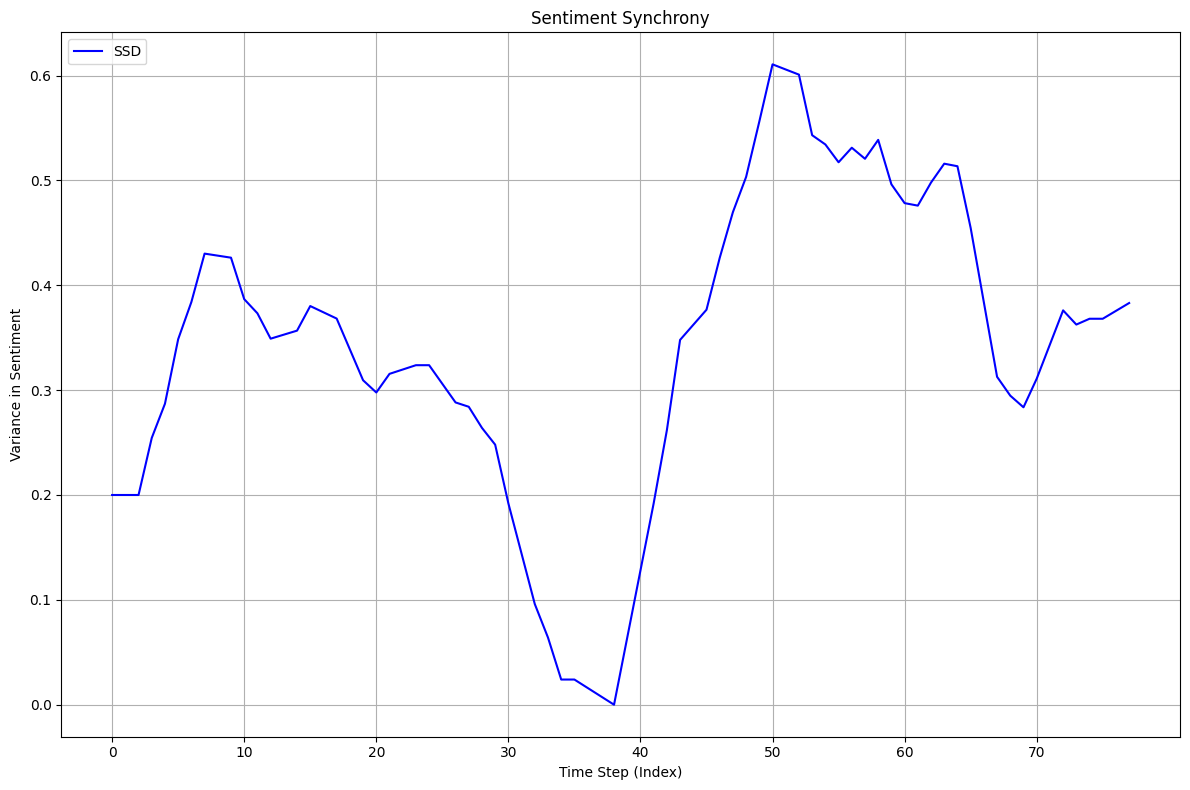

In [141]:
synch_frame_r1 = apply_SSD(ts_df[["Senti_Score_R1_P1", "Senti_Score_R1_P2", "Senti_Score_R1_P3", "Senti_Score_R1_P4", "Senti_Score_R1_P5"]])
synch_frame_bert = apply_SSD(ts_df[["Senti_Score_BERT_P1", "Senti_Score_BERT_P2", "Senti_Score_BERT_P3", "Senti_Score_BERT_P4", "Senti_Score_BERT_P5"]])
# Plot the sentiment for each speaker and model
plt.figure(figsize=(12, 8))

# Plot BERT Sentiment for each speaker
plt.plot(time_steps, synch_frame_r1['SSD'].rolling(window=5, min_periods=1).mean(), label='SSD', color='blue')


# Customize the plot
plt.title('Sentiment Synchrony')
plt.xlabel('Time Step (Index)')
plt.ylabel('Variance in Sentiment')


# Only show certain timesteps on the x-axis (every 100th timestep)
plt.xticks(range(0, len(time_steps), 10))

# Add grid lines for better readability
plt.grid(True)

# Show the legend
plt.legend(loc='upper left')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()


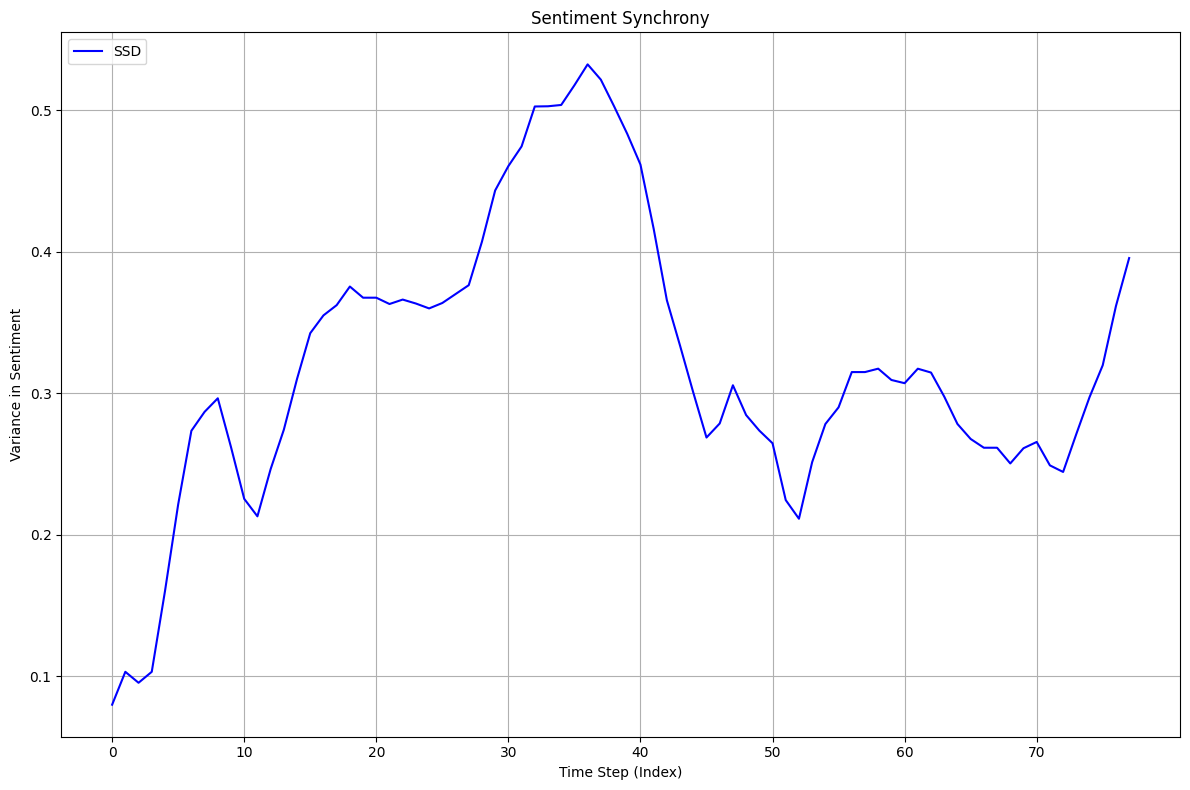

In [142]:
plt.figure(figsize=(12, 8))

# Plot BERT Sentiment for each speaker
plt.plot(time_steps, synch_frame_bert['SSD'].rolling(window=5, min_periods=1).mean(), label='SSD', color='blue')


# Customize the plot
plt.title('Sentiment Synchrony')
plt.xlabel('Time Step (Index)')
plt.ylabel('Variance in Sentiment')


# Only show certain timesteps on the x-axis (every 100th timestep)
plt.xticks(range(0, len(time_steps), 10))

# Add grid lines for better readability
plt.grid(True)

# Show the legend
plt.legend(loc='upper left')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

Schauen wir uns mal an was vor Satz 55 und 73 so ungefähr abgeht

In [136]:
pd.set_option('display.max_rows', None)
sentence_level_frame_last_szenario

Speaker                                           Sentence Senti_Score_R1  \
0       P3  Ola oder Nadia es gibt einen Lilanen vor dem L...           -0.5   
1       P4                           Vor dem Lilanen draußen?              0   
2       P4                         Okay dann komm ich zu dir.              0   
3       P2        Wollen wir dann mit Lila und Blau loslegen?            0.8   
4       P1                              Genau würd ich sagen.              0   
5       P4         Dann würde ich jetzt mit dir anfangen Ola.            0.8   
6       P3  Ja ich schaue jetzt außen rum ob ich noch Lila...            0.7   
7       P1  Ich schau auch mit nach Lila wir können ja son...           -0.2   
8       P2                            Ich seh leider nur Rot.              0   
9       P1                          Ah ich seh auch noch Rot.           -0.2   
10      P4                             Wer hat Rot als Farbe?              0   
11      P5                                               Ich.              0   
12      P4        Okay Hans dann kannst du mit Lara arbeiten.              0   
13      P1                                                Ja.              1   
14      P2                                  Und mit mir auch.              0   
15      P2                                      Mit mir auch.              0   
16      P1  Ich gehe gerade bei Lila rein ich stehe bei Li...              0   
17      P5                                              Okay.              0   
18      P5                        Du stehst bei Lila drinnen?              0   
19      P1                               Hier siehst du mich?              0   
20      P5                               Gut ja ich seh dich.            0.8   
21      P1                                Bist du bei Türkis?              0   
22      P5                                    Gut ja pass auf            0.5   
23      P1                         Ja schau hier ist der Rote              0   
24      P5                            Ja du bist Türkis oder?              0   
25      P1                                    Ich bin Türkis.              0   
26      P5  Weil da wo ich gerade stehe hinter dir der ist...              0   
27      P4                       Ola siehst du Lila irgendwo?              0   
28      P3                        Nein ich sehe einen Pinken.           -0.5   
29      P4                                    Pink siehst du?              0   
30      P3                        Nein ich seh Lila und Pink.              0   
31      P1                              Hans wo bist du denn?           -0.1   
32      P5                                       Ich bin hier              0   
33      P4                            Okay also Lila Ola Lila              0   
34      P1                                      Was ist hier?              0   
35      P1                                 Bei welcher Farbe?              0   
36      P4                   Lila wäre gut wenn du mir sagst.              0   
37      P3                                            uh huh.              0   
38      P5                                        Des bin ich              0   
39      P1                            Ahh jetzt hab ich Lila.            0.8   
40      P4                             Ich bin jetzt bei Rot.              0   
41      P2                                              Hans.              0   
42      P5                                               Ehhh           -0.2   
43      P2          Hans ich warte auf dich ich hab en Roten.            0.8   
44      P5                                              Okay.              0   
45      P4                  Ola hast du nen Lilanen irgendwo?              0   
46      P3                Nein ich sehe jetzt Pinke und Rote.           -0.7   
47      P4                         Ah du siehst Pink und Rot.              0   
48      P3                          Lilane hab ich keins mehr           -0.8   
49 